# C S 342 Final Project

## Overview

**Problem/Solution**

The project involves building a neural network to classify hand gestures from American Sign Language (ASL), specifically focusing on the 24 letters of the ASL alphabet (excluding J and Z, as they involve movement). The model aims to facilitate sign language recognition, which can enable individuals to communicate with technology or other people using sign language. Additionally, it could be expanded into touchless human-computer interactions, such as controlling devices or applications through hand gestures.


**Training Data**

The training data will be sourced from the Sign Language MNIST dataset, which contains grayscale 28x28 pixel images of hand gestures representing the 24 letters of the ASL alphabet and labeled with the corresponding ASL letter. The dataset was created by extending a small set of 1,704 uncropped color images. These images were then cropped around the hand region, converted to grayscale, resized, and augmented with over 50 variations per image using filters, random pixelation, brightness/contrast adjustments, and slight rotations. The final dataset includes 27,455 training images and 7,172 test images.


**Computational experiments**

Experiment 1 is an ablation study, where we remove or modify different parts of the model (e.g., regularization techniques, CNN layers, dropout, activation functions) to identify which components are most crucial for accurately classifying hand gestures. The goal is to better understand how the model differentiates between gestures and to find any critical features or architectural choices that improve classification performance.

Experiment 2 is a generalization study, in which the model trained on the Sign Language MNIST dataset will be evaluated on a different hand gesture dataset to test its ability to generalize and check for overfitting. If time permits, this experiment will also include testing the model in a real-time setting, where it classifies gestures from processed images captured via a camera feed.


## Loading and Understanding the Dataset

In [448]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import torch
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
import torch.nn as nn

from sklearn.metrics import confusion_matrix


In [449]:
# Load the training and test datasets

train_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')
print(f"Test dataframe shape: {test_df.shape}")
print(f"Train dataframe shape: {train_df.shape}")
train_df.head()

Test dataframe shape: (7172, 785)
Train dataframe shape: (27455, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [450]:
# Check for nulls

print(f"Nulls in train: {train_df.isnull().sum().sum()}")
print(f"Nulls in test: {test_df.isnull().sum().sum()}")

Nulls in train: 0
Nulls in test: 0


In [451]:
# Check that all pixel values for between 0 and 255

print(f"Pixel value range in train: {train_df.iloc[:, 1:].min().min()} to {train_df.iloc[:, 1:].max().max()}")
print(f"Pixel value range in test: {test_df.iloc[:, 1:].min().min()} to {test_df.iloc[:, 1:].max().max()}")

Pixel value range in train: 0 to 255
Pixel value range in test: 0 to 255


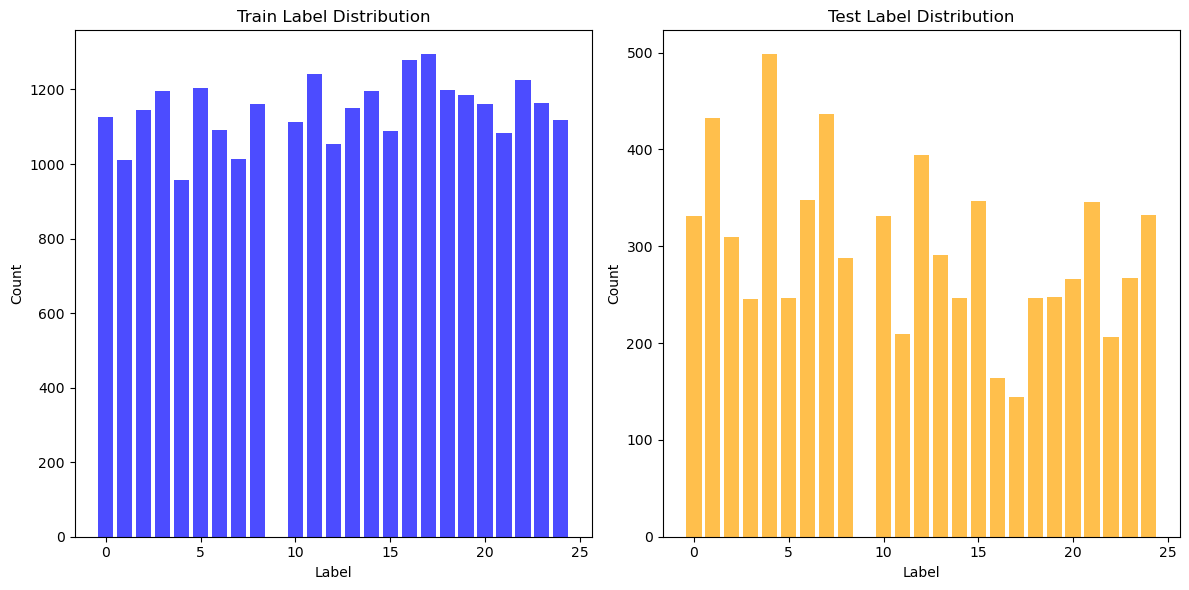

In [452]:
# Check dataset label distribution

train_labels = train_df['label'].value_counts()
test_labels = test_df['label'].value_counts()
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(train_labels.index, train_labels.values, color='blue', alpha=0.7)
plt.title('Train Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.bar(test_labels.index, test_labels.values, color='orange', alpha=0.7)
plt.title('Test Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

As we can see J (9) and Z (25) are excluded from the dataset as they involve movement.

In [453]:
# Separate the labels and features

y_train = train_df['label'].values
X_train = train_df.drop('label', axis=1).values

y_test = test_df['label'].values
X_test = test_df.drop('label', axis=1).values

In [454]:
# Reshape the data for CNN input (vector to grayscale image)

X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

In [455]:
# Show final shape of the data

print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Train labels shape: {y_train.shape}")
print(f"Test labels shape: {y_test.shape}")

Train data shape: (27455, 28, 28, 1)
Test data shape: (7172, 28, 28, 1)
Train labels shape: (27455,)
Test labels shape: (7172,)


In [456]:
# Create mappings from label to letter and vice versa

num_classes = 26
label_to_letter = {i: chr(i + 65) for i in range(num_classes)}
# del label_to_letter[9]  # J
# del label_to_letter[25] # Z
letter_to_label = {v: k for k, v in label_to_letter.items()}

print(f"Label to letter mapping: {label_to_letter}")
print(f"Letter to label mapping: {letter_to_label}")

Label to letter mapping: {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}
Letter to label mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25}


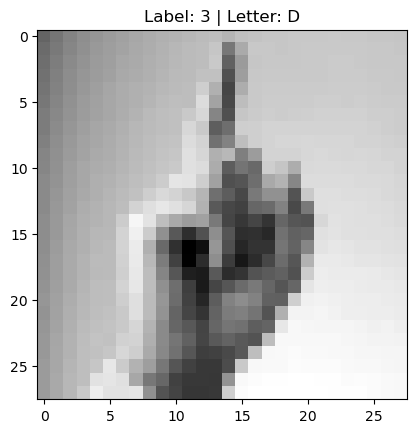

In [457]:
# Show a sample image

plt.imshow(X_train[0].reshape(28, 28), cmap='gray')
plt.title(f"Label: {y_train[0]} | Letter: {label_to_letter[y_train[0]]}")
plt.show()

In [458]:
# Convert the data to PyTorch tensors

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [459]:
# Create TensorDatasets

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [460]:
# Split the training data into training and validation sets

val_split = 0.2
num_train = len(train_dataset)
indices = list(range(len(train_dataset)))
np.random.seed(42)
np.random.shuffle(indices)
split = int(np.floor(val_split * num_train))
val_indices = indices[:split]
train_indices = indices[split:]

In [461]:
# Create samplers
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [462]:
# Create DataLoaders using the samplers

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [463]:
# Check that the DataLoader works

for images, labels in train_loader:
    print("Batch image shape:", images.shape)  # Expected: [64, 1, 28, 28]
    print("Batch label shape:", labels.shape)  # Expected: [64]
    break

Batch image shape: torch.Size([64, 1, 28, 28])
Batch label shape: torch.Size([64])


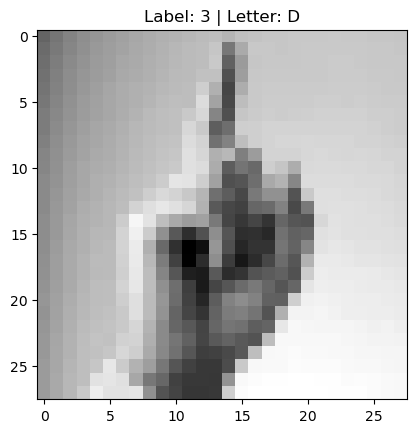

In [500]:
# Check that images are still in the correct format after tensor conversion

plt.imshow(X_train_tensor[0].squeeze().numpy(), cmap='gray')
plt.title(f"Label: {y_train_tensor[0].item()} | Letter: {label_to_letter[y_train_tensor[0].item()]}")
plt.show()

## Training the Model

In [465]:
# Define the training and validation function

def train_model(model, criterion, optimizer, train_loader, val_loader, nepochs=10):

    train_losses = []
    val_losses = []

    for epoch in range(nepochs):
        # ----- VALIDATION -----
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for val_images, val_labels in val_loader:
                val_outputs = model(val_images)
                loss = criterion(val_outputs, val_labels)

                val_loss += loss.item()
                _, val_predicted = torch.max(val_outputs, 1)
                val_total += val_labels.size(0)
                val_correct += (val_predicted == val_labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # ----- TRAINING -----
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        print(f"Epoch [{epoch+1}/{nepochs}] "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
              f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")
        
    return train_losses, val_losses


In [466]:
# Define the testing function

def test_model(model, test_loader, criterion, num_classes=num_classes):
    model.eval()
    total = 0
    correct = 0
    total_loss = 0.0

    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    wrong_predictions = []
    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(test_loader):
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            for i in range(len(labels)):
                label = labels[i].item()
                pred = predicted[i].item()

                class_total[label] += 1
                if pred == label:
                    class_correct[label] += 1
                else:
                    wrong_predictions.append({
                        'true': label,
                        'predicted': pred,
                        'index': batch_idx * test_loader.batch_size + i
                    })
                
                true_labels.append(label)
                pred_labels.append(pred)

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(test_loader)

    cm = confusion_matrix(true_labels, pred_labels, labels=list(range(num_classes)))
    
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")

    return class_correct, class_total, wrong_predictions, cm


In [467]:
# Plot the training and validation losses over the epochs

def plot_losses_over_epochs(train_losses, val_losses, nepochs):
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, nepochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, nepochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss over Epochs')
    plt.legend()
    plt.show()

In [468]:
# Plot the accuracy for each class label

def plot_class_accuracies(class_correct, class_total, label_to_letter):
    class_accuracies = {label: (class_correct[label] / class_total[label]) * 100 for label in class_correct}
    
    # Set the accuracies for J (9) and Z (25) to 0 as per the dataset's omission
    class_accuracies[9] = 0
    class_accuracies[25] = 0

    sorted_labels = sorted(class_accuracies.keys())
    sorted_accuracies = [class_accuracies[label] for label in sorted_labels]
    x_labels = [f"{label}:{label_to_letter[label]}" for label in sorted_labels]


    plt.figure(figsize=(16, 5))
    plt.bar(x_labels, sorted_accuracies, color='skyblue')
    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy per Class')
    plt.xticks(sorted_labels)
    plt.show()

    print(sorted_labels)
    print(sorted_accuracies)

In [469]:
# Print the most correct and incorrect class

def print_most_correct_and_incorrect(class_correct, class_total):
    accuracies = {label: (class_correct[label] / class_total[label]) * 100 for label in class_correct}

    most_correct = max(accuracies, key=accuracies.get)
    most_incorrect = min(accuracies, key=accuracies.get)

    print(f"Most Correct: Label {most_correct}, Accuracy: {accuracies[most_correct]:.2f}%")
    print(f"Most Incorrect: Label {most_incorrect}, Accuracy: {accuracies[most_incorrect]:.2f}%")

In [470]:
# Plot the confusion matrix

def plot_confusion_matrix(cm, num_classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(range(num_classes)), yticklabels=list(range(num_classes)))

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [536]:
# Plot a comparizon between a misclassified example and a correct example

def show_prediction_comparison(true_label, pred_label, wrong_preds, test_loader):
    # Find the misclassified example
    wrong_img = None
    for wp in wrong_preds:
        if wp['predicted'] == pred_label and wp['true'] == true_label:
            idx = wp['index']
            wrong_img, _ = test_loader.dataset[idx]
            break

    # Find a correct example of the predicted label
    correct_img = None
    for i in range(len(test_loader.dataset)):
        img, label = test_loader.dataset[i]
        if label == pred_label:
            correct_img = img
            break

    # Plot both images side by side
    if wrong_img is not None and correct_img is not None:
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        # Title formatting with optional letters
        if label_to_letter:
            true_str = f"{true_label}:{label_to_letter.get(true_label, '?')}"
            pred_str = f"{pred_label}:{label_to_letter.get(pred_label, '?')}"
        else:
            true_str = str(true_label)
            pred_str = str(pred_label)

        axes[0].imshow(wrong_img.squeeze(), cmap='gray')
        axes[0].set_title(f"True {true_str} | Pred {pred_str}")
        axes[0].axis('off')

        axes[1].imshow(correct_img.squeeze(), cmap='gray')
        axes[1].set_title(f"Reference: {pred_str}")
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()
    else:
        print("Could not find one or both images.")

In [538]:
# Show commonly misclassified pairs

def find_and_show_misclassified_pairs(cm, num_classes, wrong_preds, test_loader, threshold=10, show_prediction_comparison_func=None):
    misclassified_pairs = []

    for true_label in range(num_classes):
        for pred_label in range(num_classes):
            if true_label != pred_label and cm[true_label][pred_label] > threshold:
                misclassified_pairs.append((true_label, pred_label))

    for true_label, pred_label in misclassified_pairs:
        if show_prediction_comparison_func:
            show_prediction_comparison_func(true_label, pred_label, wrong_preds, test_loader)

In [539]:
# Full training, testing, and evalution pipeline

def run_full_pipeline(model, criterion, optimizer, 
                      train_loader, val_loader, test_loader,
                      label_to_letter, num_classes, 
                      nepochs=10, misclass_threshold=10, 
                      show_prediction_comparison_func=None):
    """
    Trains the model, evaluates it, and runs all analysis/visualization steps.
    """
    # Train the model
    train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, nepochs)

    # Test the model
    class_correct, class_total, wrong_preds, cm = test_model(model, test_loader, criterion, num_classes)

    # Plot loss curves
    plot_losses_over_epochs(train_losses, val_losses, nepochs)

    # Plot class-level accuracy
    plot_class_accuracies(class_correct, class_total, label_to_letter)

    # Print most correct and incorrect labels
    print_most_correct_and_incorrect(class_correct, class_total)

    # Plot the confusion matrix
    plot_confusion_matrix(cm, num_classes)

    # Analyze frequent misclassifications
    find_and_show_misclassified_pairs(
        cm=cm,
        num_classes=num_classes,
        wrong_preds=wrong_preds,
        test_loader=test_loader,
        threshold=misclass_threshold,
        show_prediction_comparison_func=show_prediction_comparison_func
    )


In [474]:
# Define our model

class SignLanguageCNN(nn.Module):
    def __init__(self):
        super(SignLanguageCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)


c:\Users\ExoHorizon\anaconda3\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/10] Train Loss: 2.7544, Train Acc: 21.97% | Val Loss: 7.6862, Val Acc: 3.72%
Epoch [2/10] Train Loss: 1.3547, Train Acc: 65.06% | Val Loss: 1.8654, Val Acc: 66.31%
Epoch [3/10] Train Loss: 0.6081, Train Acc: 87.43% | Val Loss: 0.7158, Val Acc: 93.39%
Epoch [4/10] Train Loss: 0.3017, Train Acc: 95.51% | Val Loss: 0.2921, Val Acc: 98.73%
Epoch [5/10] Train Loss: 0.1534, Train Acc: 98.53% | Val Loss: 0.1103, Val Acc: 99.82%
Epoch [6/10] Train Loss: 0.0896, Train Acc: 99.31% | Val Loss: 0.0468, Val Acc: 99.91%
Epoch [7/10] Train Loss: 0.0560, Train Acc: 99.65% | Val Loss: 0.0227, Val Acc: 99.95%
Epoch [8/10] Train Loss: 0.0385, Train Acc: 99.82% | Val Loss: 0.0150, Val Acc: 99.91%
Epoch [9/10] Train Loss: 0.0282, Train Acc: 99.86% | Val Loss: 0.0073, Val Acc: 99.96%
Epoch [10/10] Train Loss: 0.0208, Train Acc: 99.89% | Val Loss: 0.0070, Val Acc: 99.93%
Test Loss: 0.1054, Test Accuracy: 97.48%


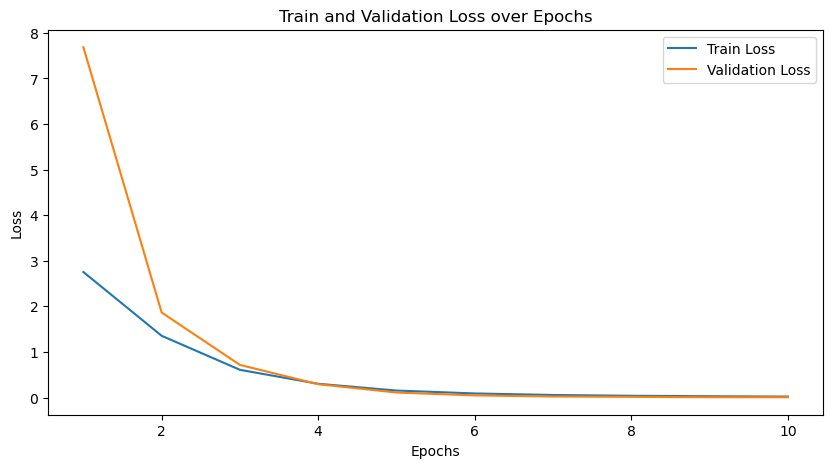

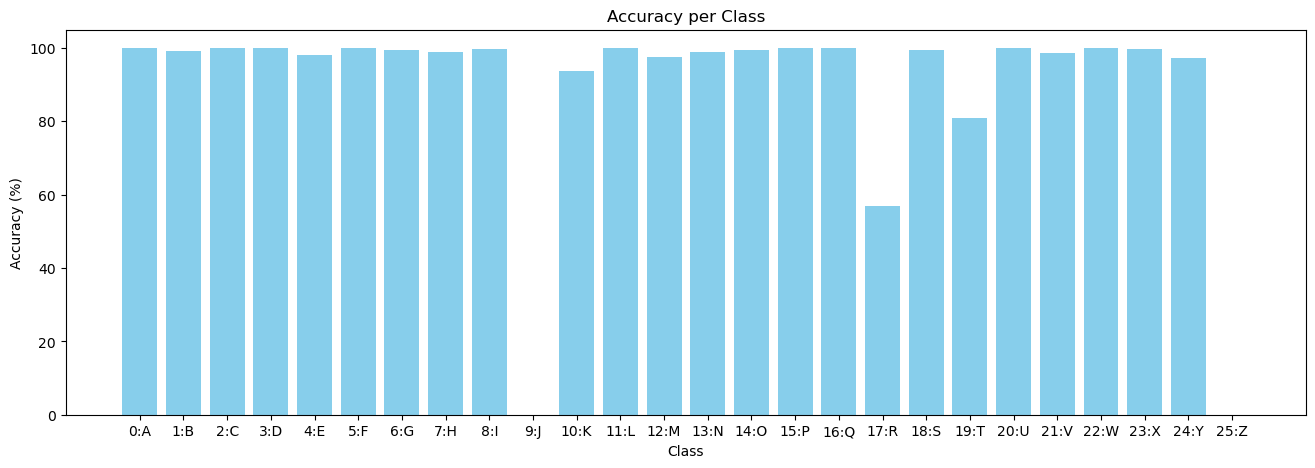

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[100.0, 99.30555555555556, 100.0, 100.0, 97.99196787148594, 100.0, 99.42528735632183, 98.85321100917432, 99.65277777777779, 0, 93.65558912386706, 100.0, 97.46192893401016, 98.96907216494846, 99.59349593495935, 100.0, 100.0, 56.94444444444444, 99.59349593495935, 81.04838709677419, 100.0, 98.55491329479769, 100.0, 99.625468164794, 97.28915662650603, 0]
Most Correct: Label 5, Accuracy: 100.00%
Most Incorrect: Label 17, Accuracy: 56.94%


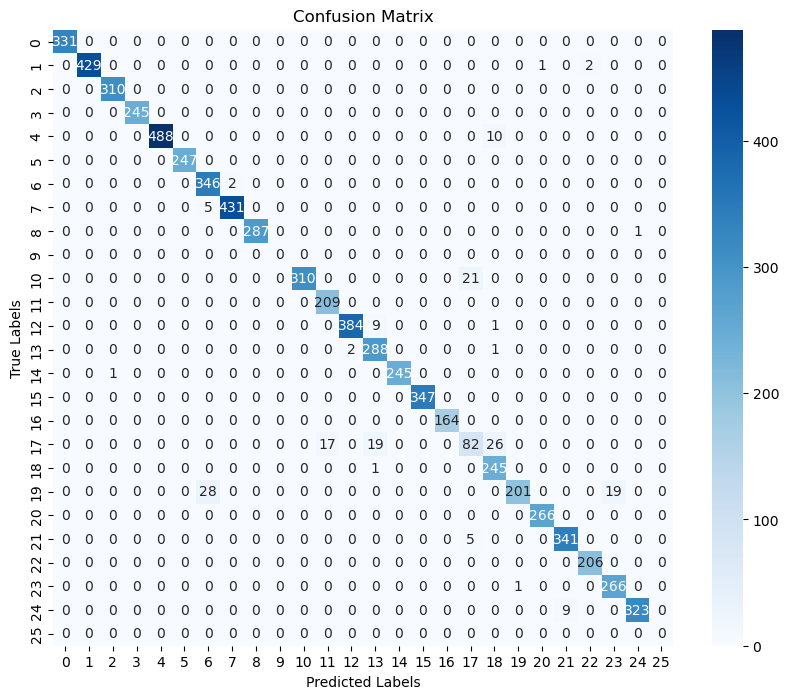

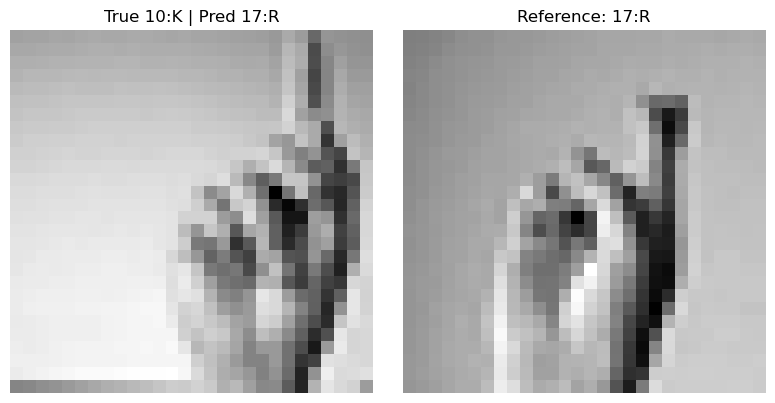

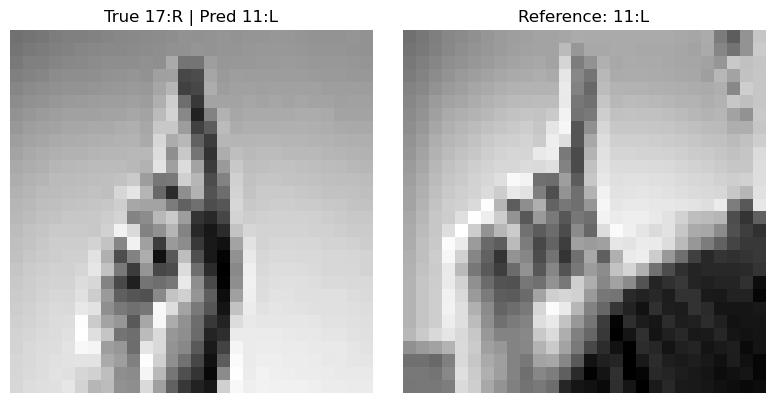

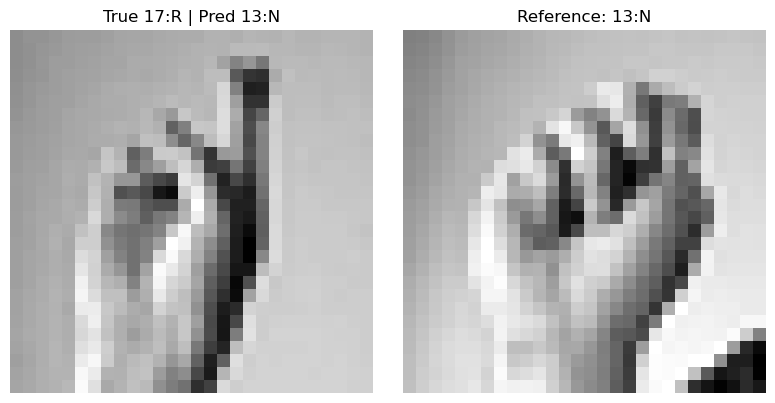

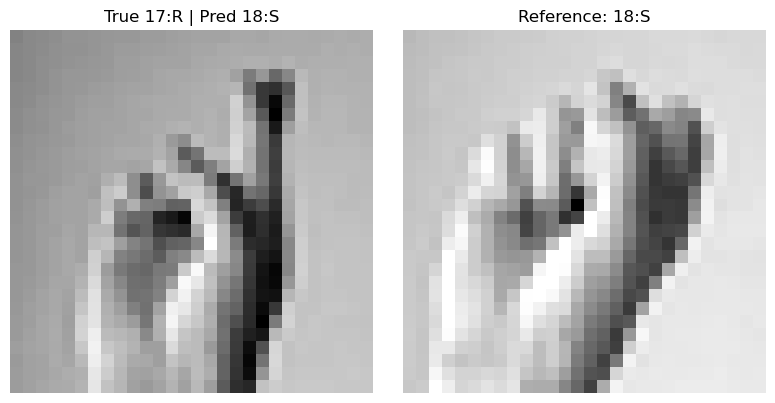

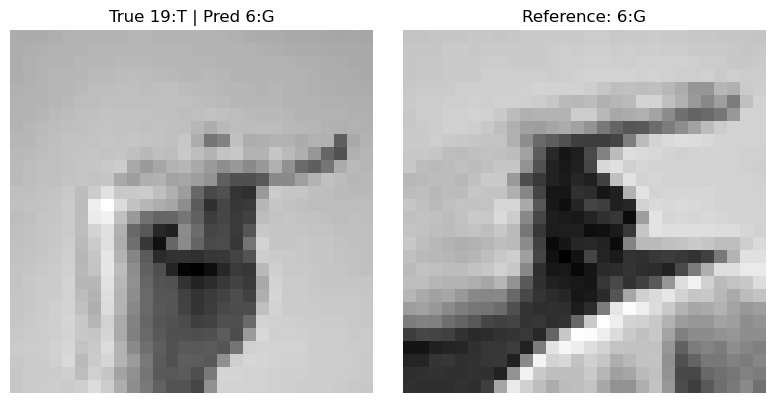

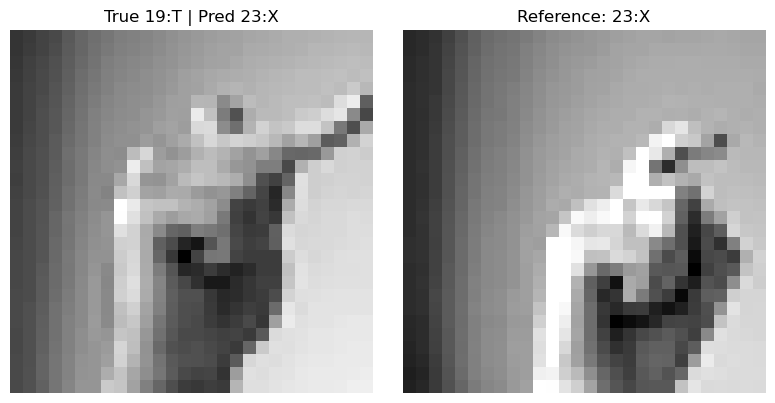

In [475]:
# Run Pipeline For the Model

model = SignLanguageCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

run_full_pipeline(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    label_to_letter=label_to_letter,
    num_classes=num_classes,
    nepochs=10,
    misclass_threshold=10,
    show_prediction_comparison_func=show_prediction_comparison
)


## Experiment 1: Ablation Study

c:\Users\ExoHorizon\anaconda3\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/10] Train Loss: 2.2995, Train Acc: 46.23% | Val Loss: 8.5256, Val Acc: 3.81%
Epoch [2/10] Train Loss: 0.6663, Train Acc: 93.50% | Val Loss: 1.2156, Val Acc: 80.09%
Epoch [3/10] Train Loss: 0.1923, Train Acc: 99.49% | Val Loss: 0.3222, Val Acc: 98.16%
Epoch [4/10] Train Loss: 0.0680, Train Acc: 99.96% | Val Loss: 0.0965, Val Acc: 99.91%
Epoch [5/10] Train Loss: 0.0320, Train Acc: 100.00% | Val Loss: 0.0415, Val Acc: 99.98%
Epoch [6/10] Train Loss: 0.0174, Train Acc: 100.00% | Val Loss: 0.0185, Val Acc: 100.00%
Epoch [7/10] Train Loss: 0.0109, Train Acc: 100.00% | Val Loss: 0.0128, Val Acc: 99.98%
Epoch [8/10] Train Loss: 0.0072, Train Acc: 100.00% | Val Loss: 0.0076, Val Acc: 100.00%
Epoch [9/10] Train Loss: 0.0049, Train Acc: 100.00% | Val Loss: 0.0057, Val Acc: 100.00%
Epoch [10/10] Train Loss: 0.0037, Train Acc: 100.00% | Val Loss: 0.0034, Val Acc: 100.00%
Test Loss: 0.0961, Test Accuracy: 97.38%


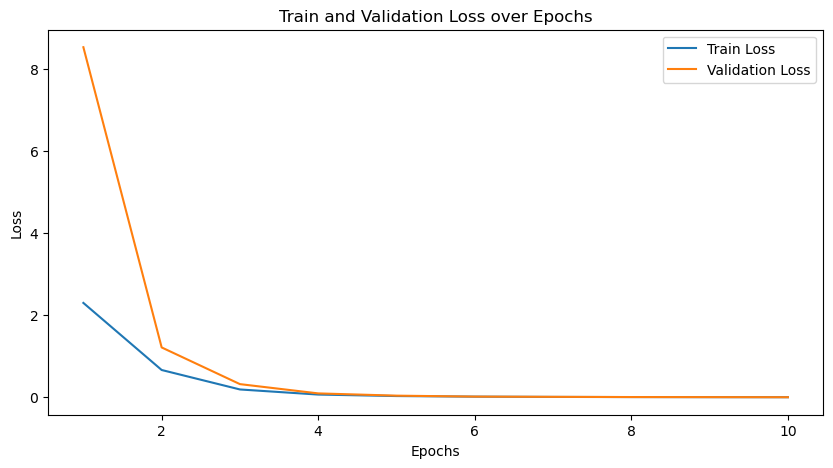

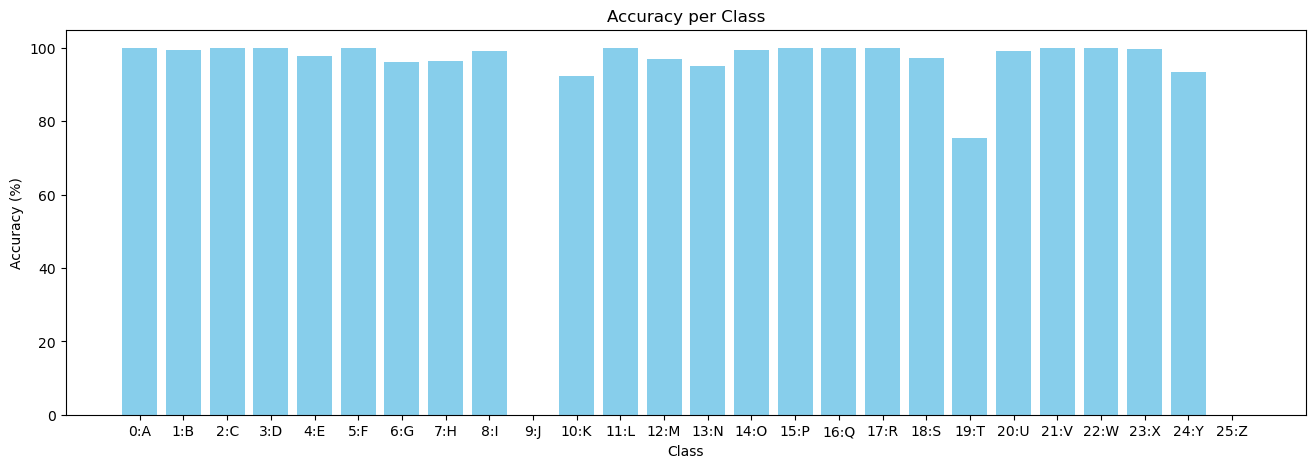

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[100.0, 99.53703703703704, 100.0, 100.0, 97.79116465863453, 100.0, 96.26436781609196, 96.55963302752293, 99.30555555555556, 0, 92.44712990936556, 100.0, 96.95431472081218, 95.1890034364261, 99.59349593495935, 100.0, 100.0, 100.0, 97.15447154471545, 75.40322580645162, 99.24812030075188, 100.0, 100.0, 99.625468164794, 93.37349397590361, 0]
Most Correct: Label 5, Accuracy: 100.00%
Most Incorrect: Label 19, Accuracy: 75.40%


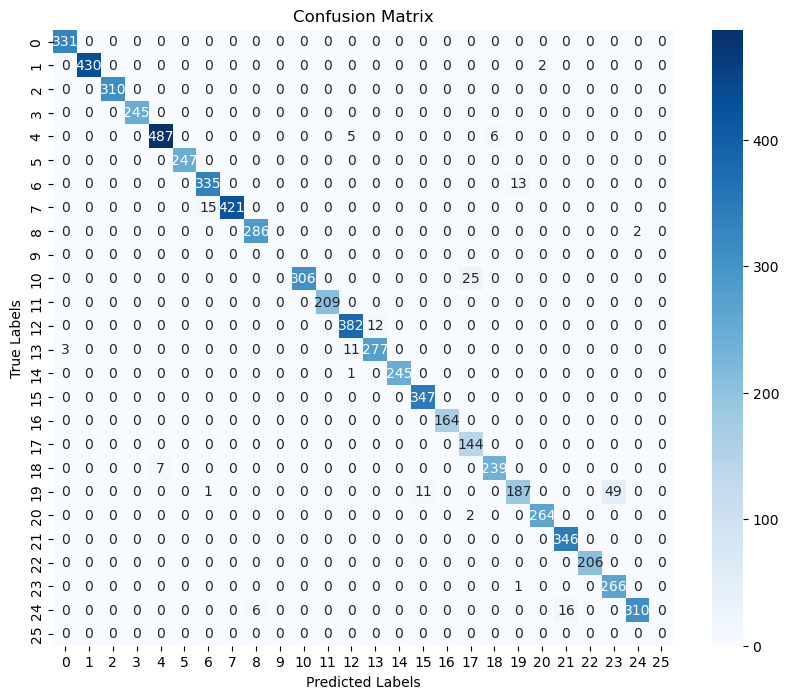

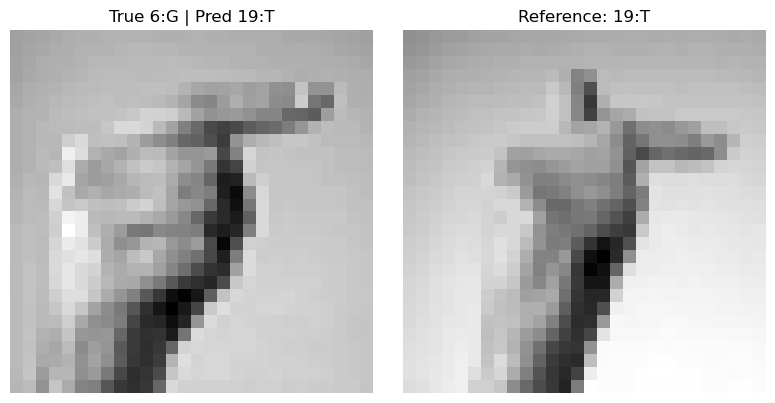

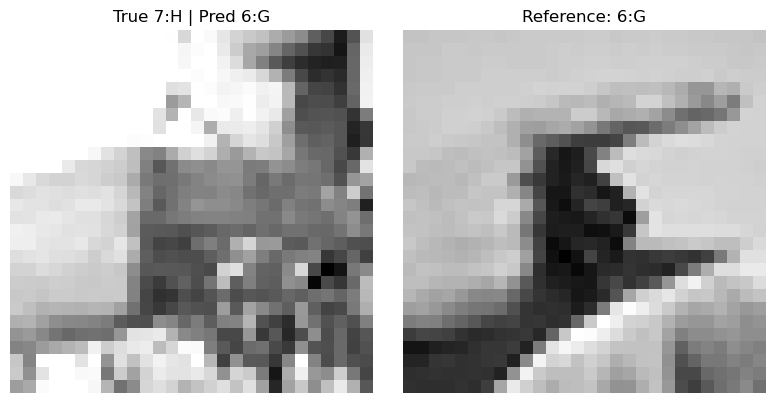

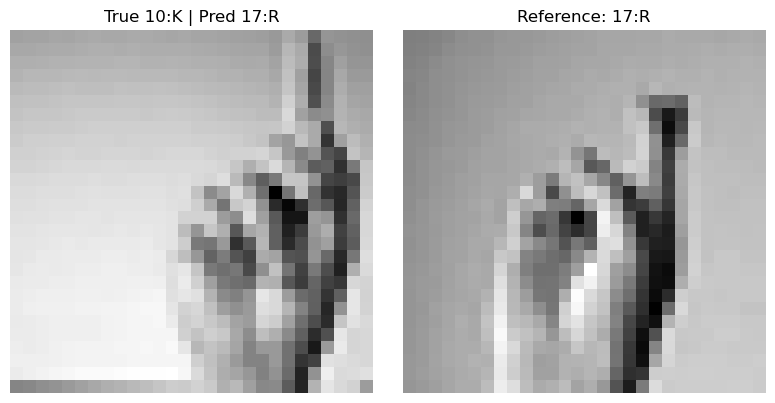

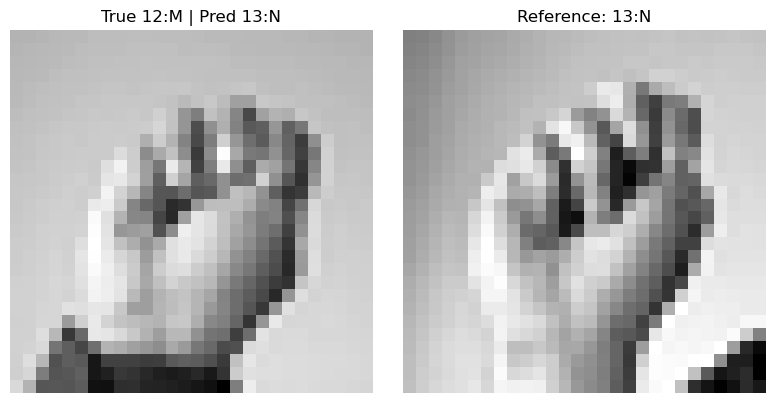

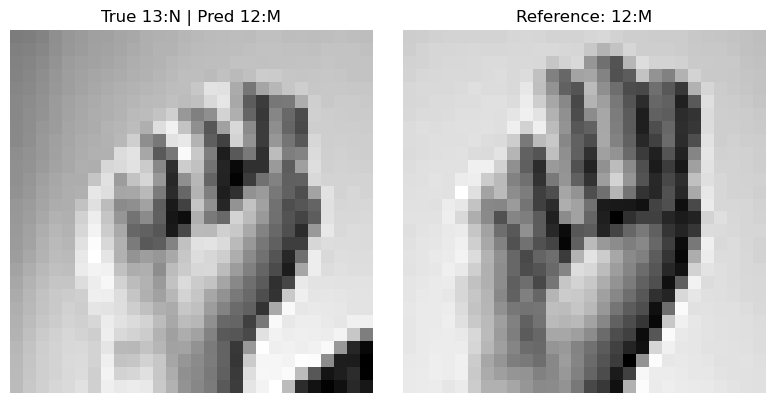

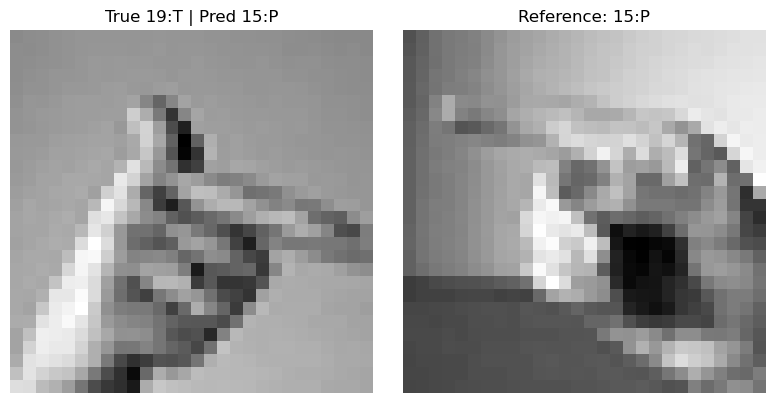

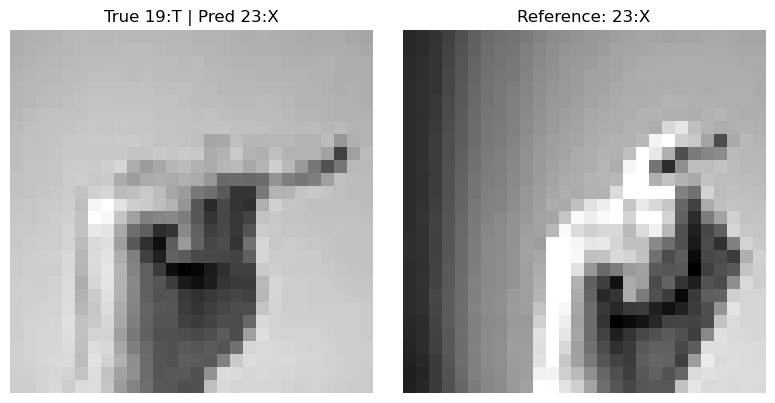

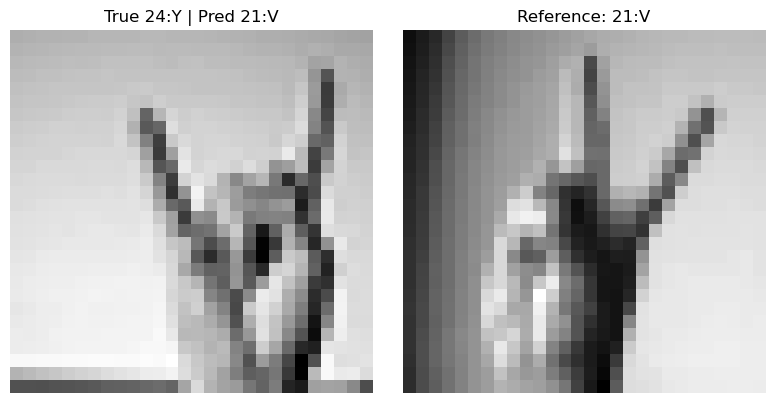

In [476]:
# No Dropout

class NoDropoutCNN(nn.Module):
    def __init__(self):
        super(NoDropoutCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)


model_no_dropout = NoDropoutCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_no_dropout.parameters(), lr=0.0001)

run_full_pipeline(
    model=model_no_dropout,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    label_to_letter=label_to_letter,
    num_classes=num_classes,
    nepochs=10,
    misclass_threshold=10,
    show_prediction_comparison_func=show_prediction_comparison
)

c:\Users\ExoHorizon\anaconda3\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/10] Train Loss: 3.2145, Train Acc: 9.89% | Val Loss: 6.6820, Val Acc: 3.46%
Epoch [2/10] Train Loss: 2.3931, Train Acc: 27.09% | Val Loss: 2.6509, Val Acc: 28.32%
Epoch [3/10] Train Loss: 1.7382, Train Acc: 44.56% | Val Loss: 1.7593, Val Acc: 51.65%
Epoch [4/10] Train Loss: 1.2647, Train Acc: 58.68% | Val Loss: 1.1867, Val Acc: 68.95%
Epoch [5/10] Train Loss: 0.9279, Train Acc: 69.76% | Val Loss: 0.7846, Val Acc: 81.92%
Epoch [6/10] Train Loss: 0.7327, Train Acc: 75.76% | Val Loss: 0.5432, Val Acc: 86.54%
Epoch [7/10] Train Loss: 0.5701, Train Acc: 81.32% | Val Loss: 0.4058, Val Acc: 91.15%
Epoch [8/10] Train Loss: 0.4560, Train Acc: 85.13% | Val Loss: 0.2887, Val Acc: 94.48%
Epoch [9/10] Train Loss: 0.3694, Train Acc: 88.13% | Val Loss: 0.2389, Val Acc: 94.97%
Epoch [10/10] Train Loss: 0.3076, Train Acc: 90.29% | Val Loss: 0.1538, Val Acc: 97.41%
Test Loss: 0.3588, Test Accuracy: 87.66%


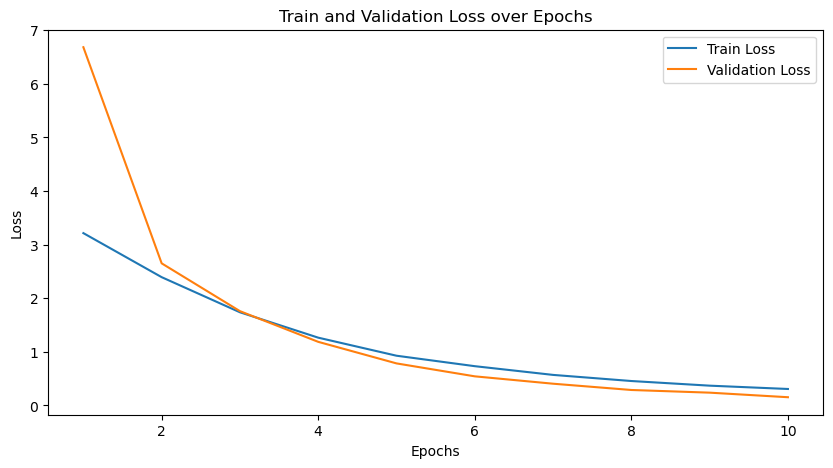

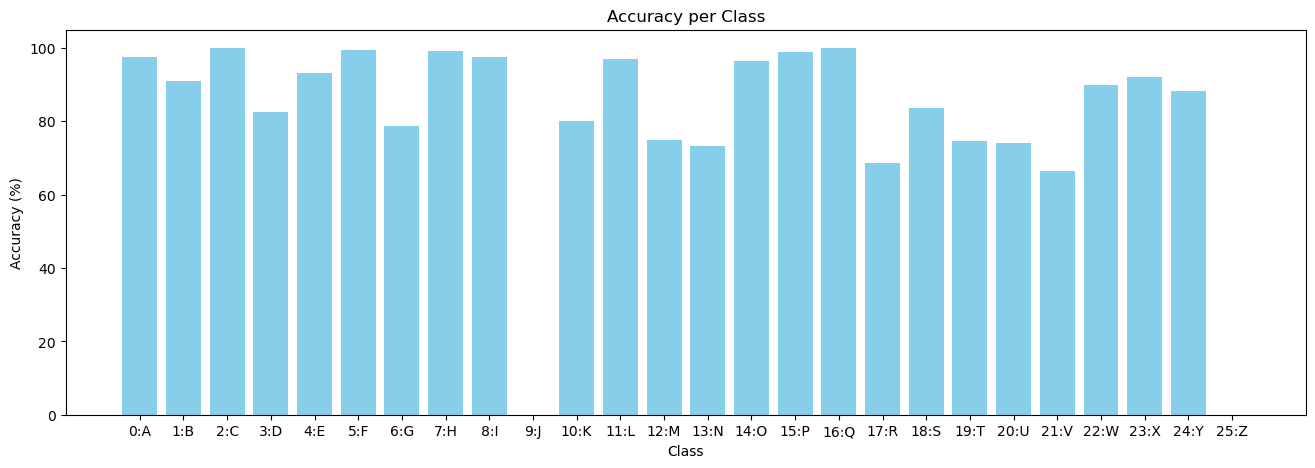

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[97.58308157099698, 90.97222222222221, 100.0, 82.44897959183673, 93.17269076305222, 99.59514170040485, 78.73563218390804, 99.31192660550458, 97.56944444444444, 0, 80.06042296072508, 97.1291866028708, 74.8730964467005, 73.19587628865979, 96.34146341463415, 98.84726224783861, 100.0, 68.75, 83.73983739837398, 74.59677419354838, 74.06015037593986, 66.47398843930635, 89.80582524271846, 92.13483146067416, 88.25301204819277, 0]
Most Correct: Label 2, Accuracy: 100.00%
Most Incorrect: Label 21, Accuracy: 66.47%


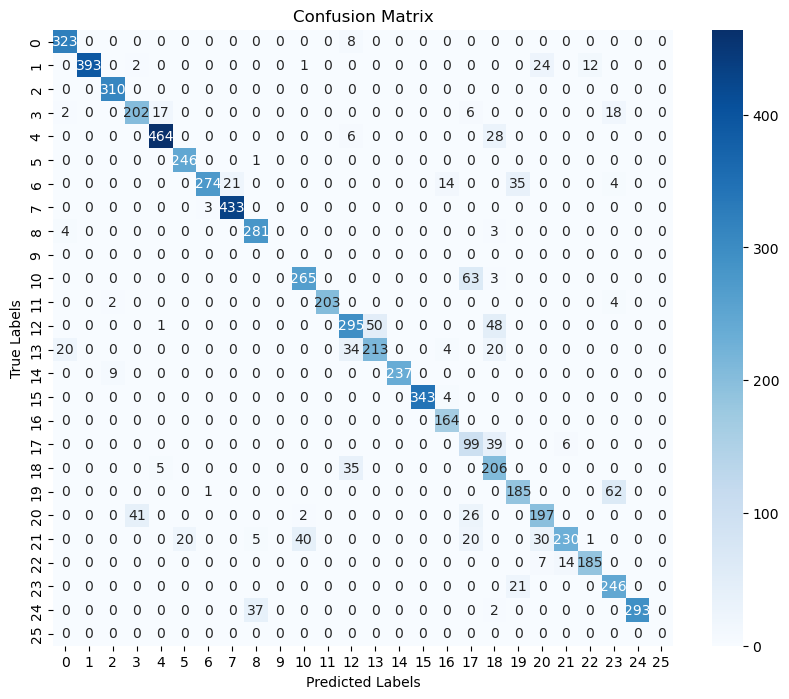

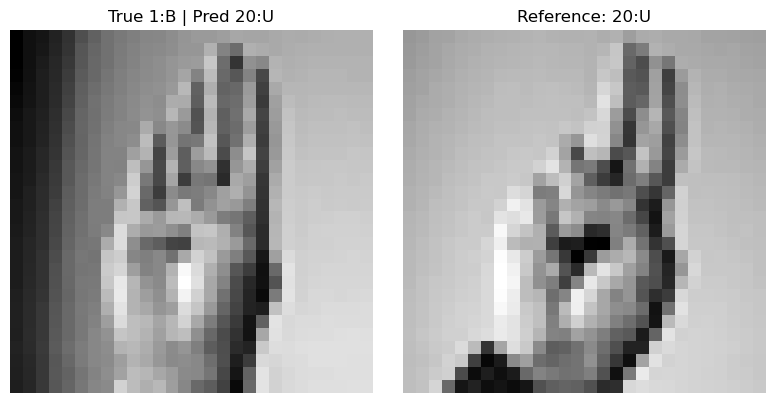

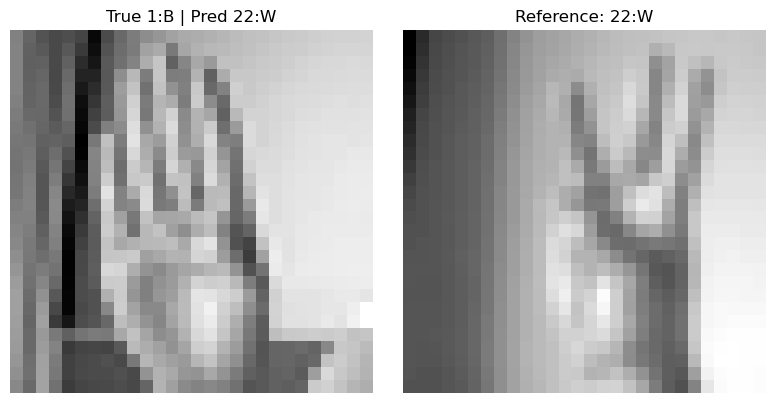

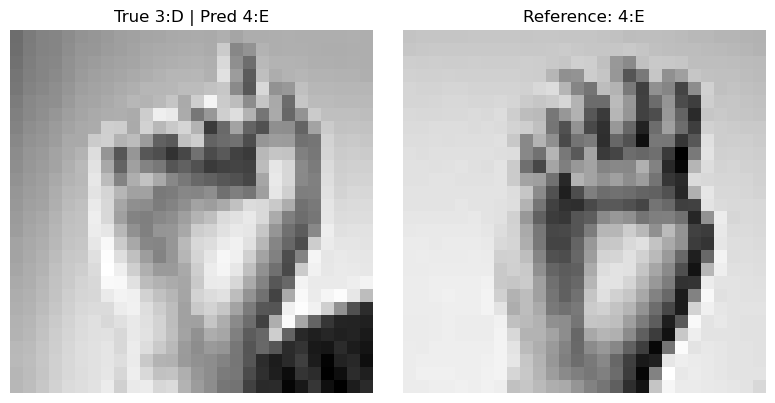

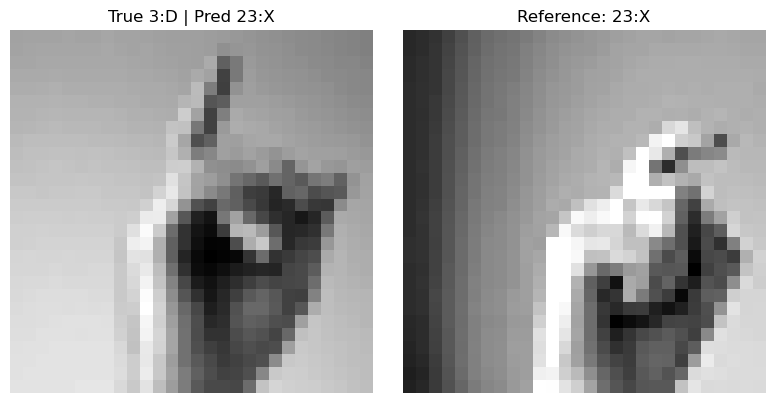

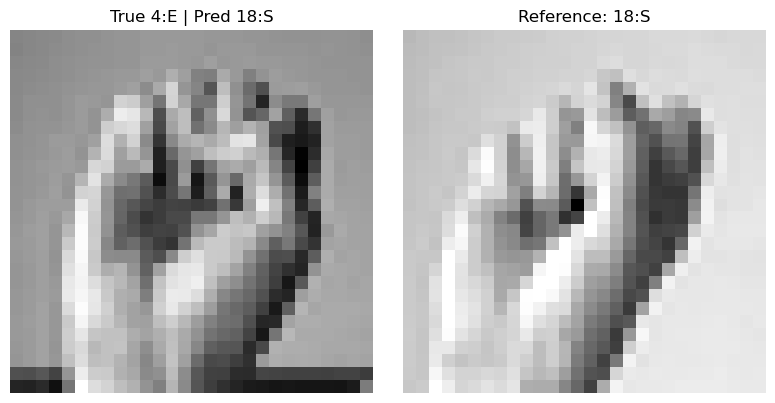

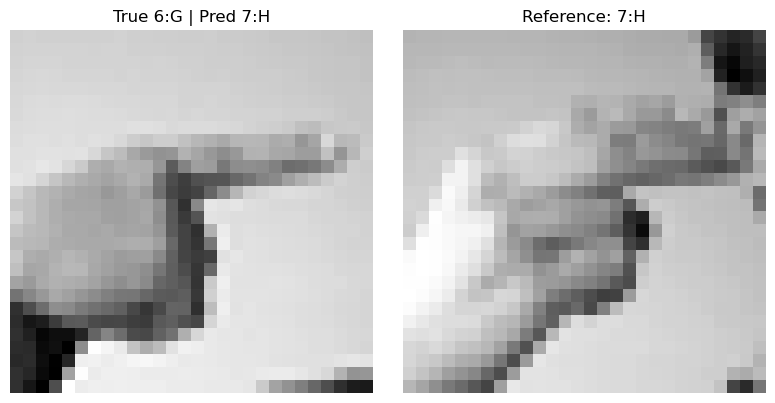

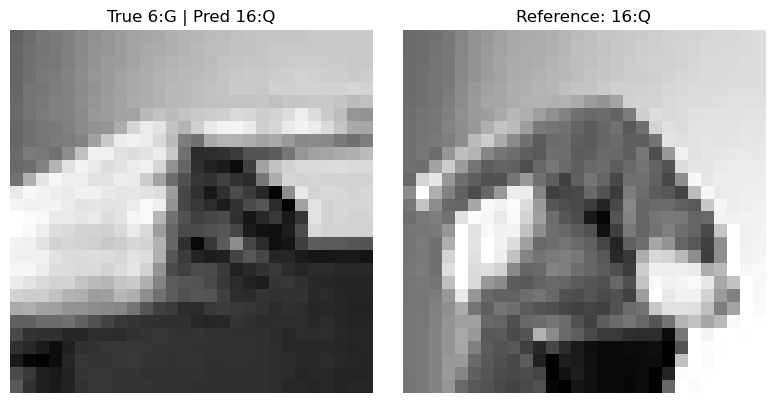

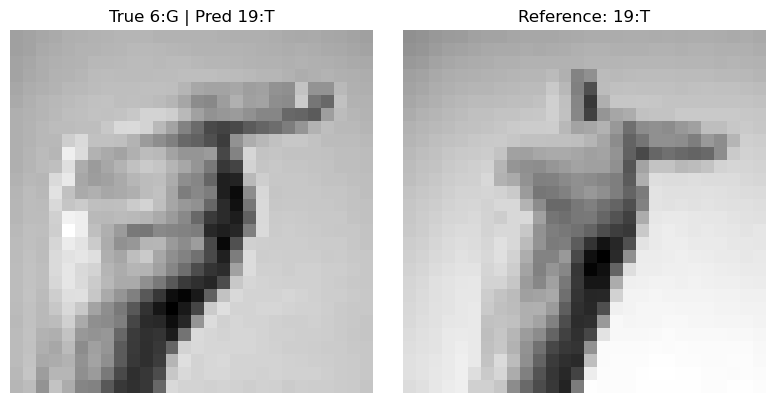

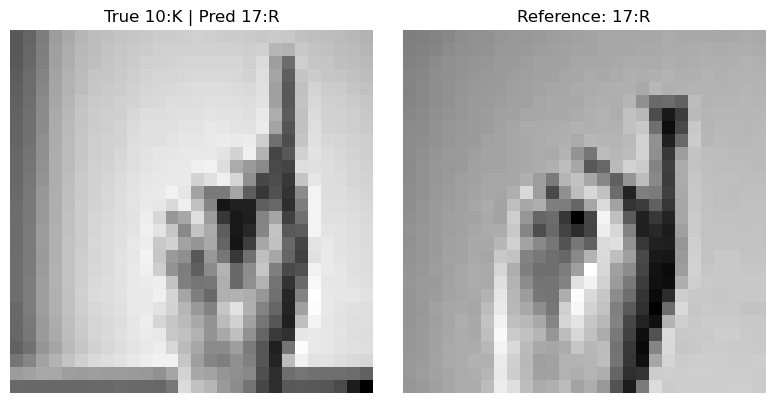

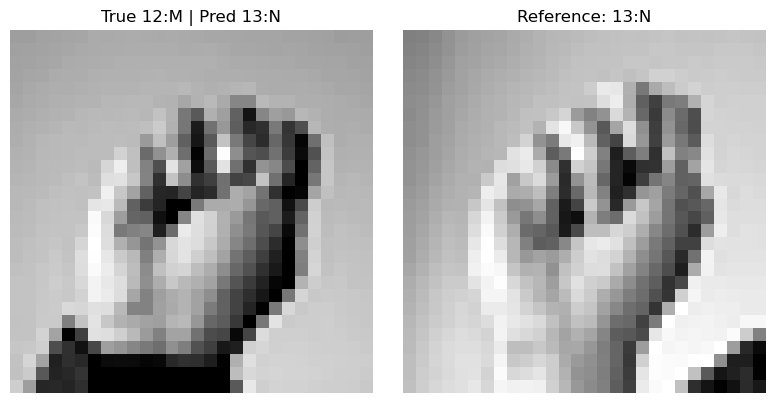

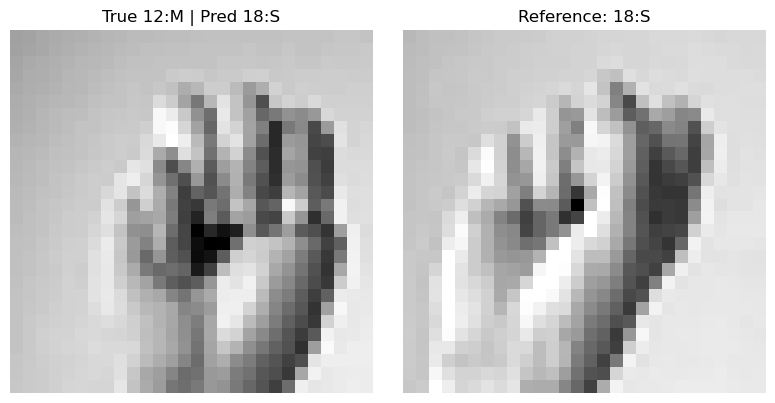

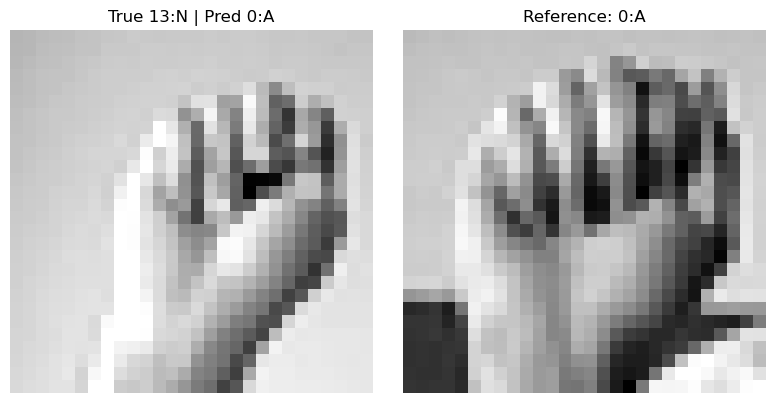

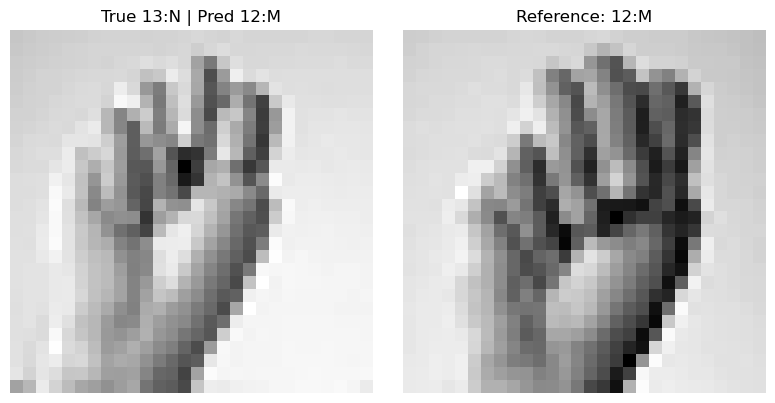

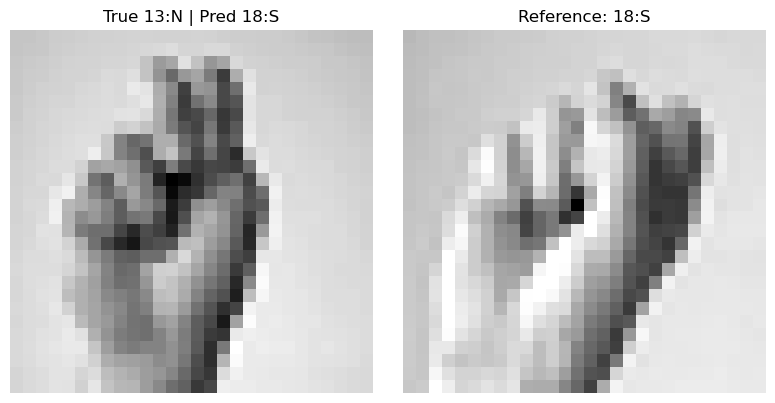

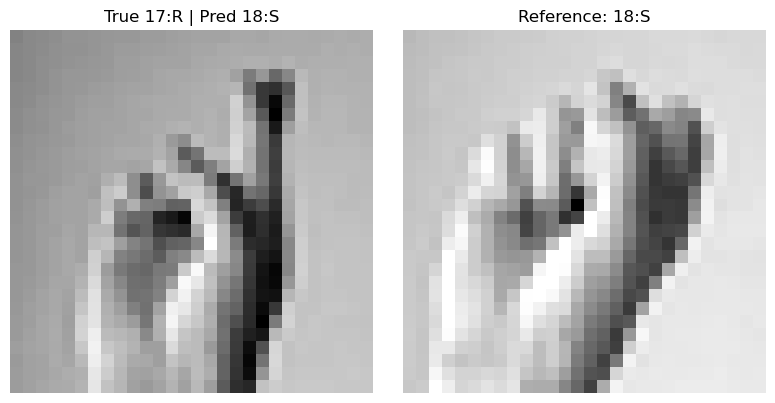

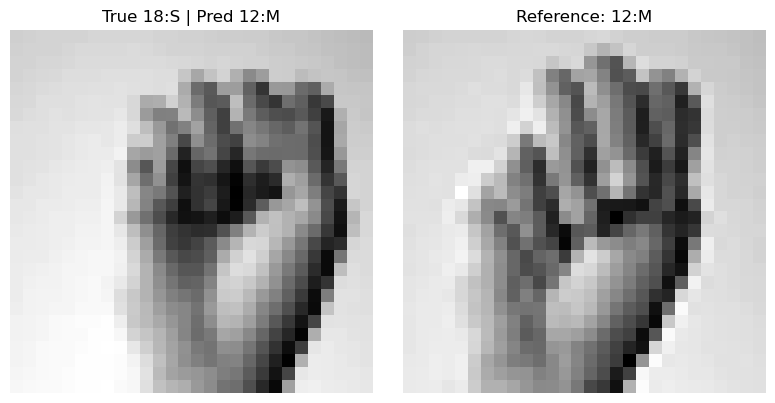

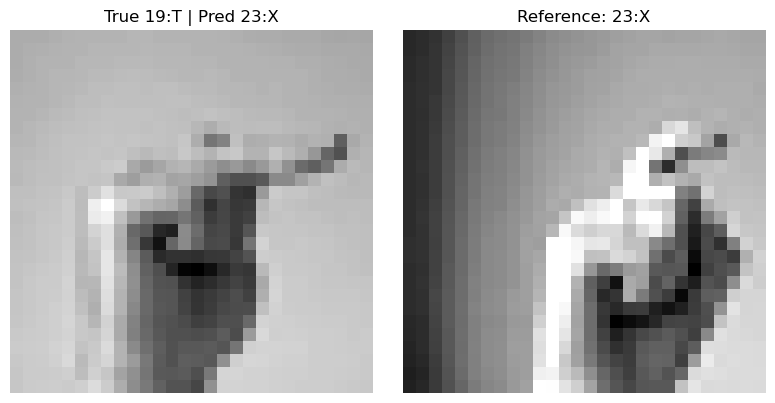

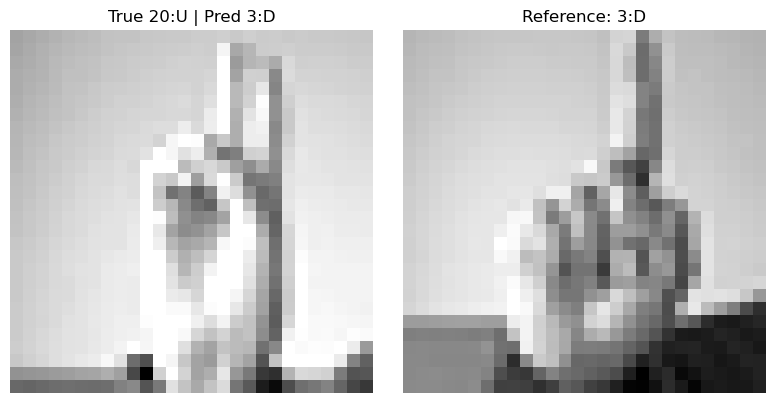

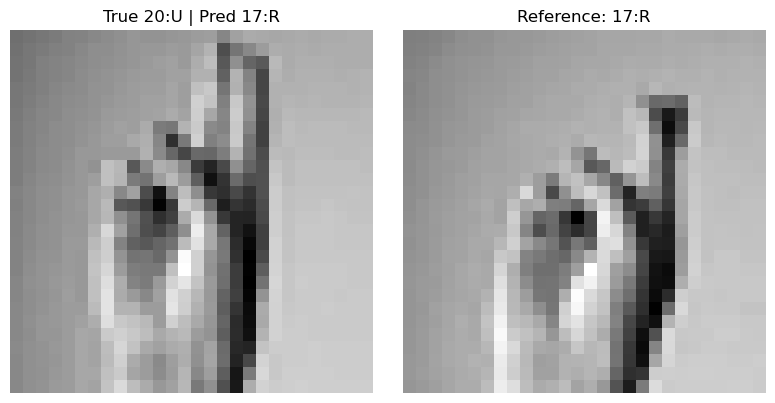

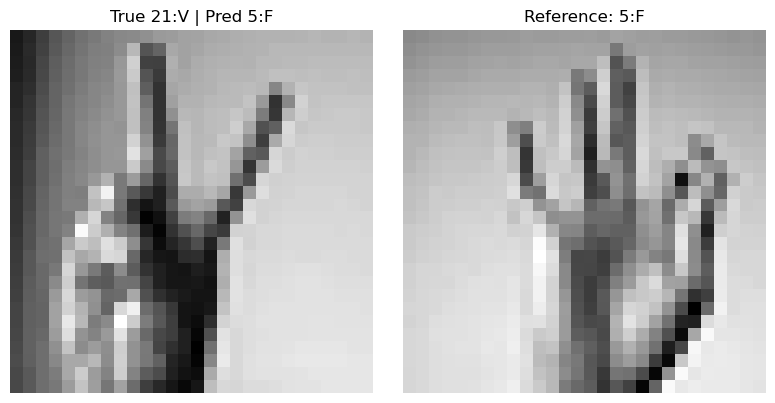

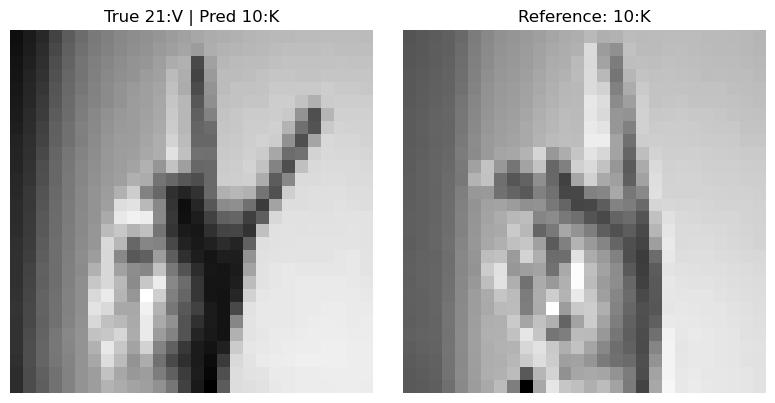

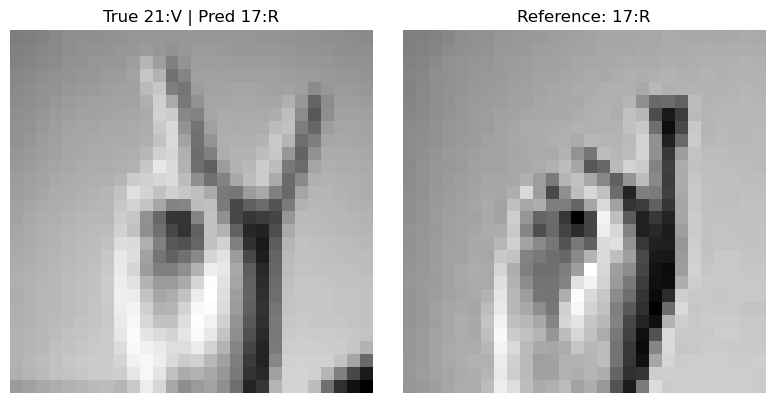

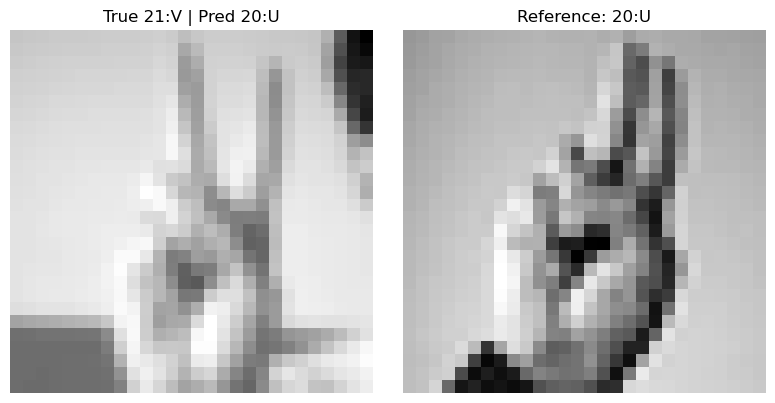

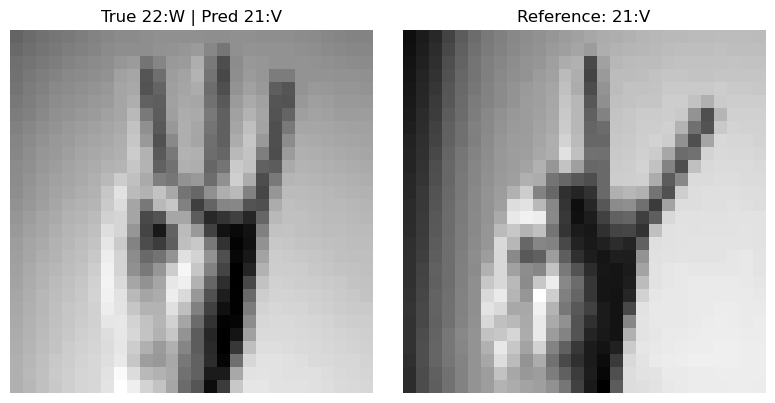

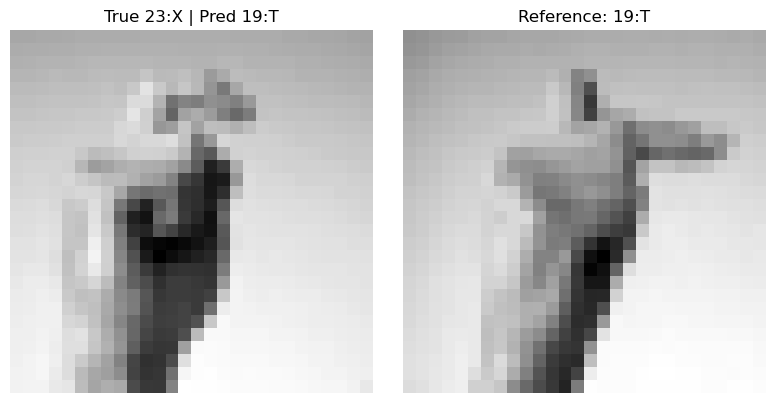

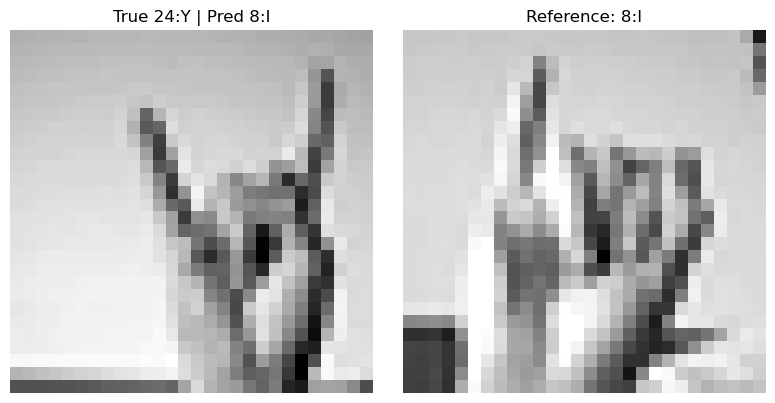

In [478]:
class NoBatchNormCNN(nn.Module):
    def __init__(self):
        super(NoBatchNormCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)


model_no_batch_norm = NoBatchNormCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_no_batch_norm.parameters(), lr=0.0001)

run_full_pipeline(
    model=model_no_batch_norm,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    label_to_letter=label_to_letter,
    num_classes=num_classes,
    nepochs=10,
    misclass_threshold=10,
    show_prediction_comparison_func=show_prediction_comparison
)

c:\Users\ExoHorizon\anaconda3\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/10] Train Loss: 3.1714, Train Acc: 7.98% | Val Loss: 12.3220, Val Acc: 4.13%
Epoch [2/10] Train Loss: 2.8134, Train Acc: 19.76% | Val Loss: 3.0331, Val Acc: 19.10%
Epoch [3/10] Train Loss: 2.1971, Train Acc: 35.41% | Val Loss: 2.4297, Val Acc: 37.86%
Epoch [4/10] Train Loss: 1.7338, Train Acc: 46.82% | Val Loss: 1.7851, Val Acc: 55.47%
Epoch [5/10] Train Loss: 1.4379, Train Acc: 54.68% | Val Loss: 1.4200, Val Acc: 65.91%
Epoch [6/10] Train Loss: 1.2144, Train Acc: 62.21% | Val Loss: 1.1812, Val Acc: 71.21%
Epoch [7/10] Train Loss: 1.0366, Train Acc: 67.93% | Val Loss: 0.9622, Val Acc: 78.80%
Epoch [8/10] Train Loss: 0.8970, Train Acc: 72.79% | Val Loss: 0.8246, Val Acc: 82.26%
Epoch [9/10] Train Loss: 0.7710, Train Acc: 77.92% | Val Loss: 0.7730, Val Acc: 81.30%
Epoch [10/10] Train Loss: 0.6619, Train Acc: 81.38% | Val Loss: 0.6000, Val Acc: 87.69%
Test Loss: 0.6369, Test Accuracy: 83.39%


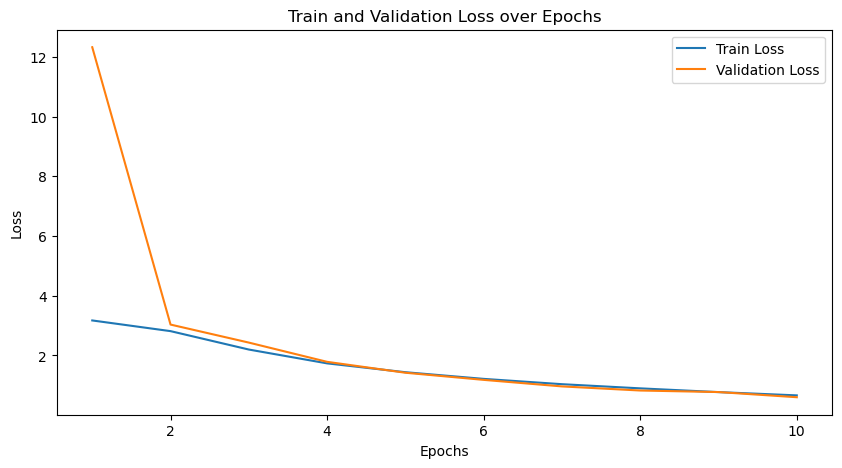

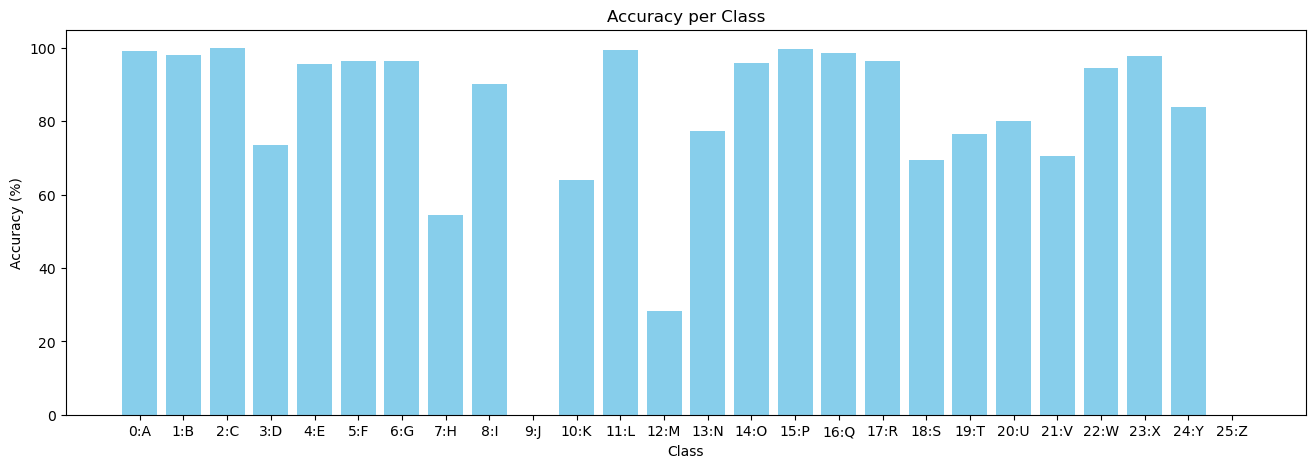

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[99.09365558912387, 98.14814814814815, 100.0, 73.46938775510205, 95.58232931726907, 96.35627530364373, 96.55172413793103, 54.357798165137616, 90.27777777777779, 0, 64.04833836858006, 99.52153110047847, 28.17258883248731, 77.31958762886599, 95.9349593495935, 99.71181556195965, 98.78048780487805, 96.52777777777779, 69.51219512195121, 76.61290322580645, 80.07518796992481, 70.52023121387283, 94.66019417475728, 97.75280898876404, 84.03614457831326, 0]
Most Correct: Label 2, Accuracy: 100.00%
Most Incorrect: Label 12, Accuracy: 28.17%


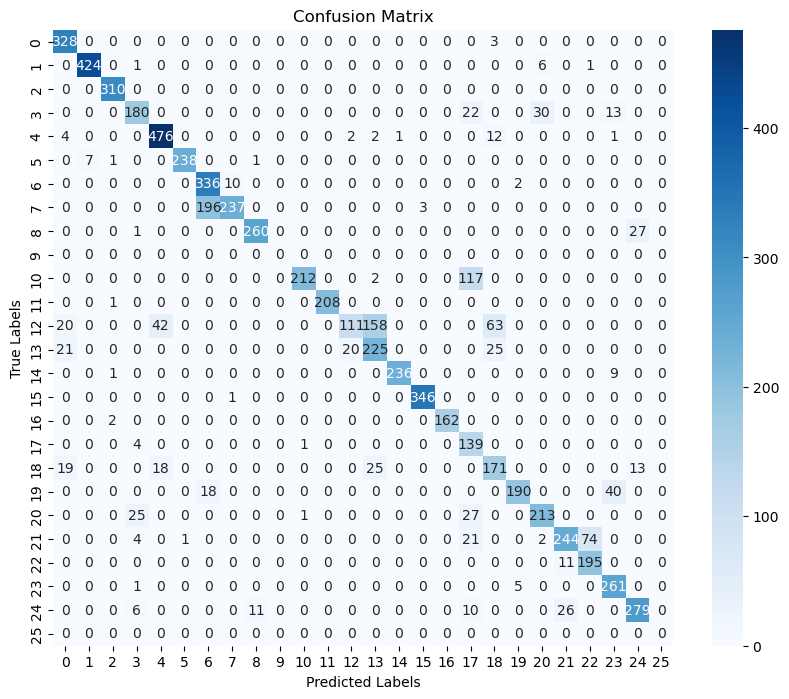

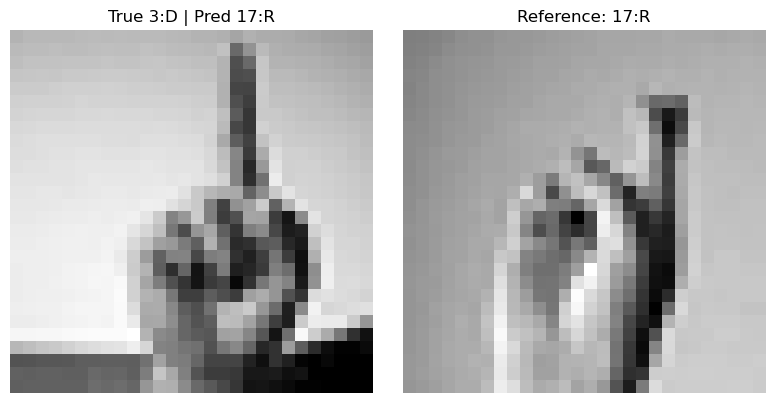

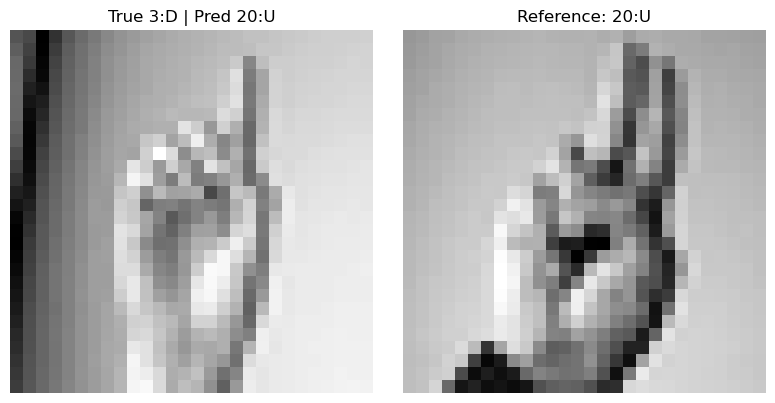

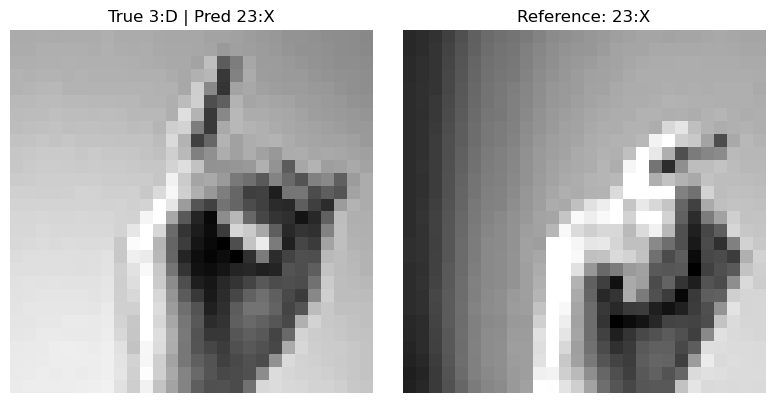

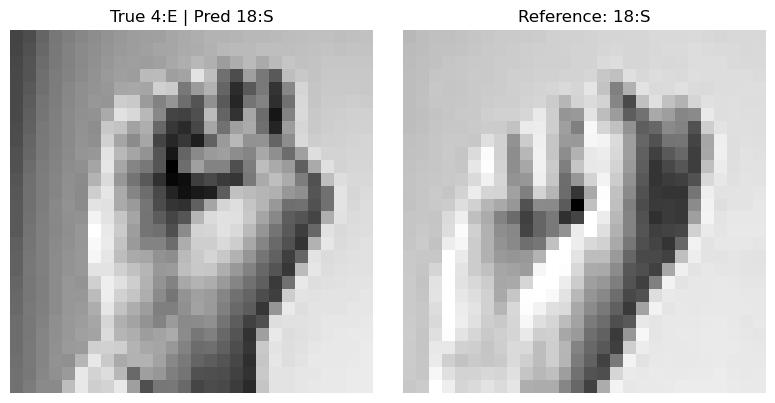

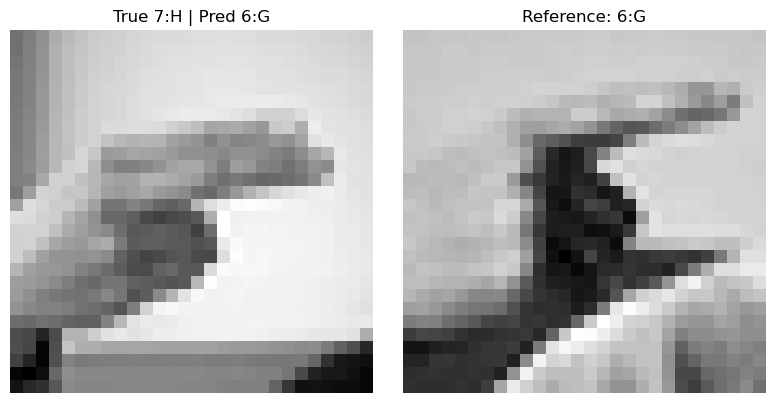

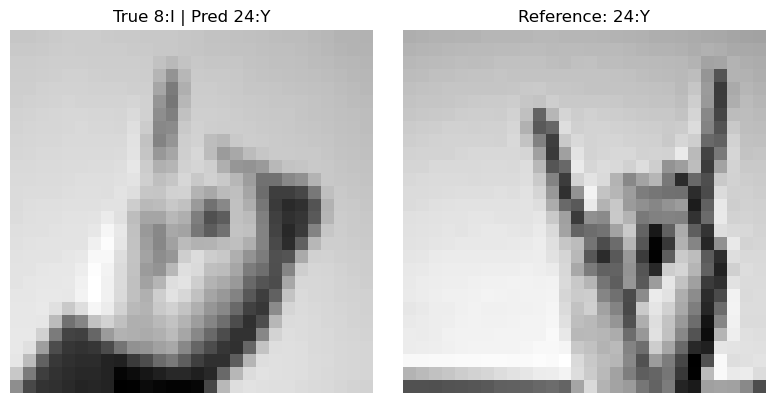

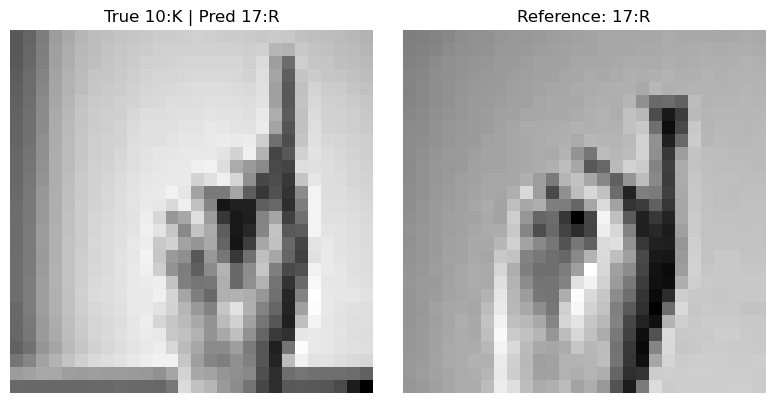

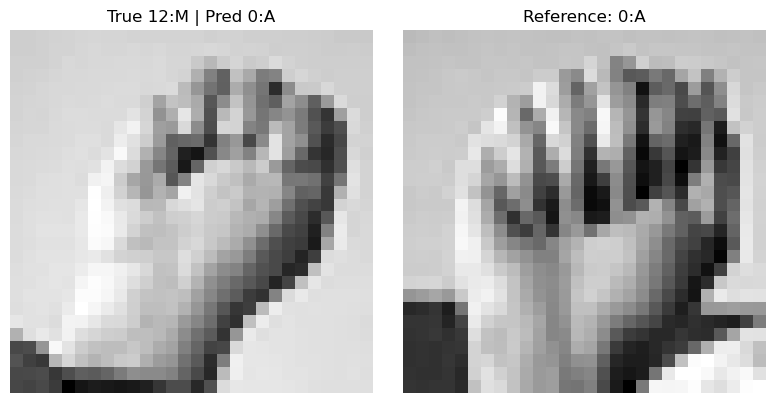

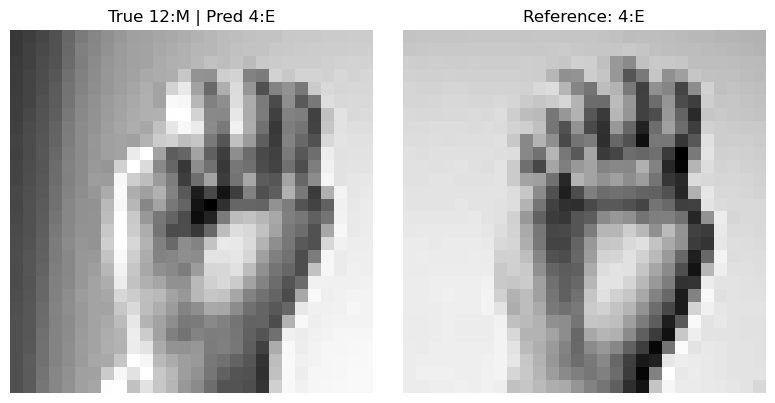

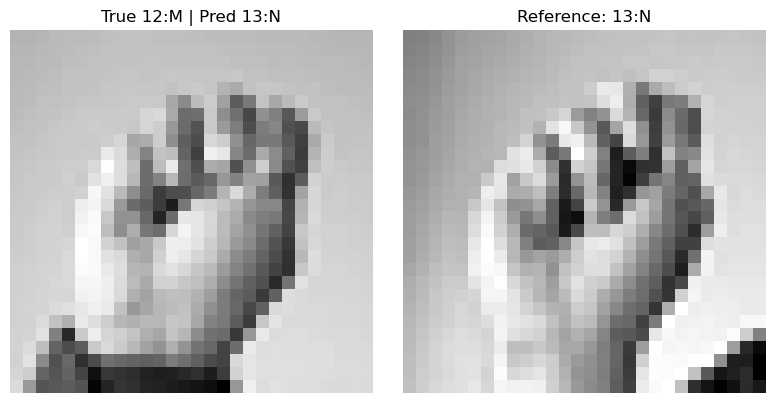

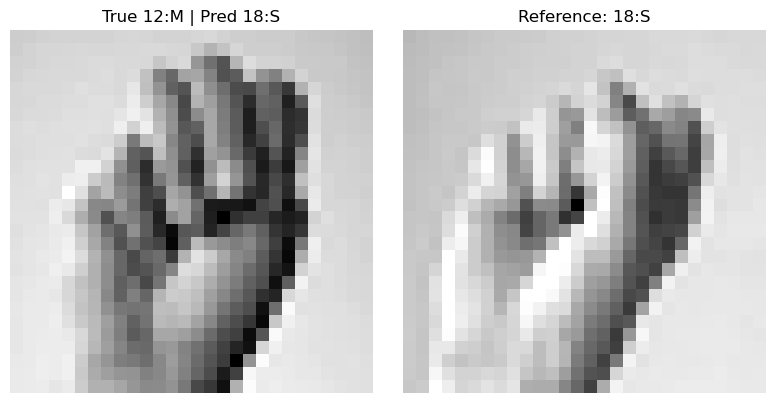

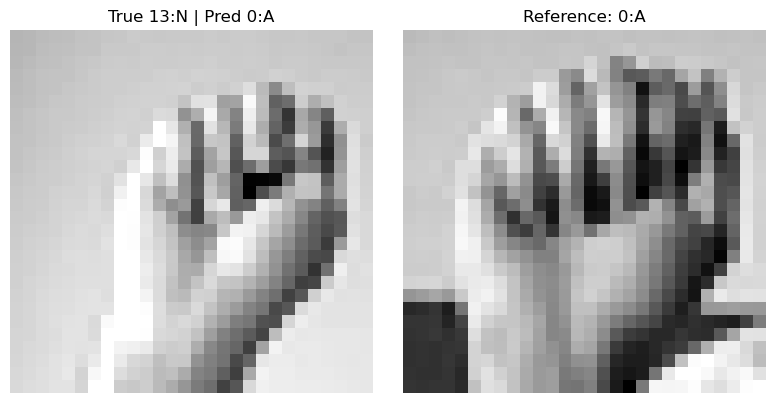

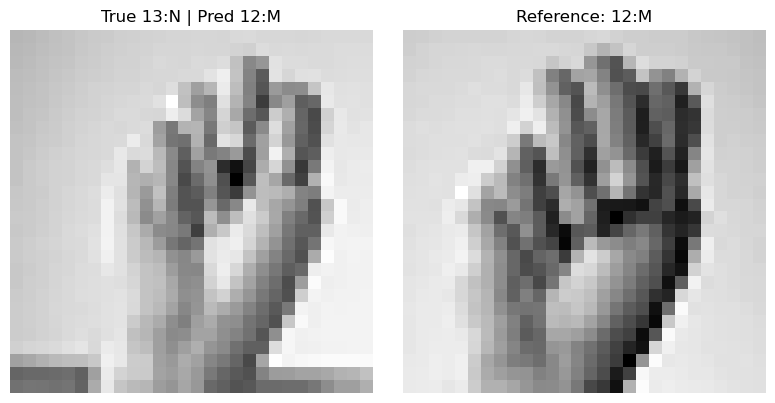

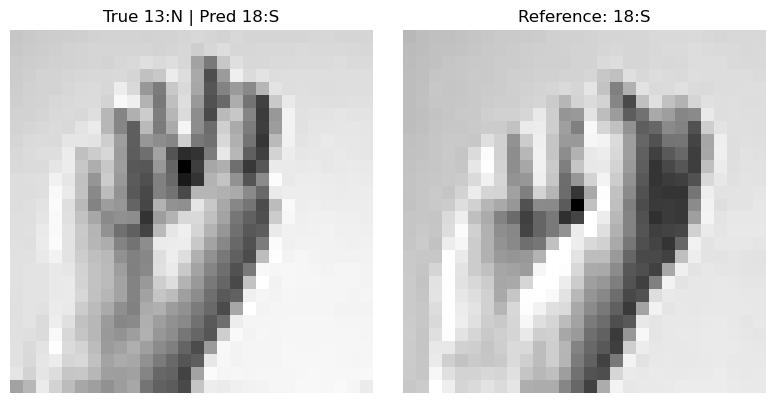

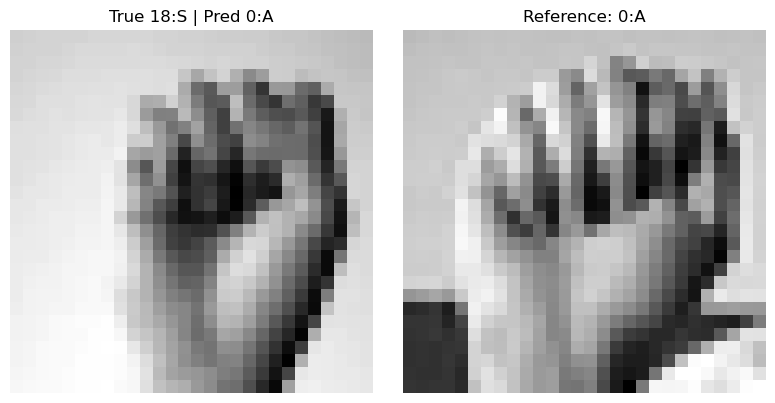

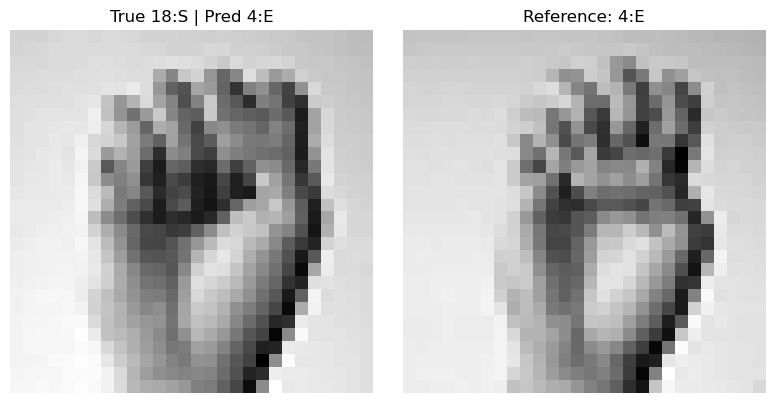

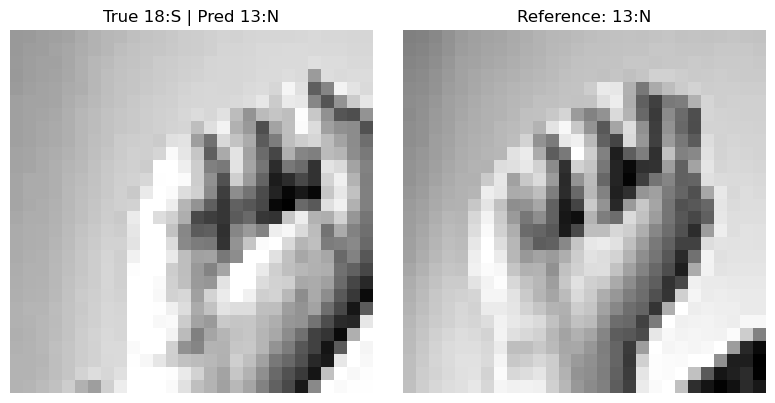

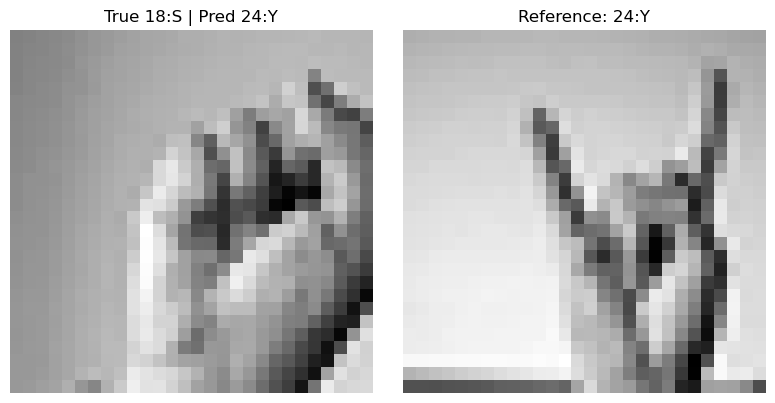

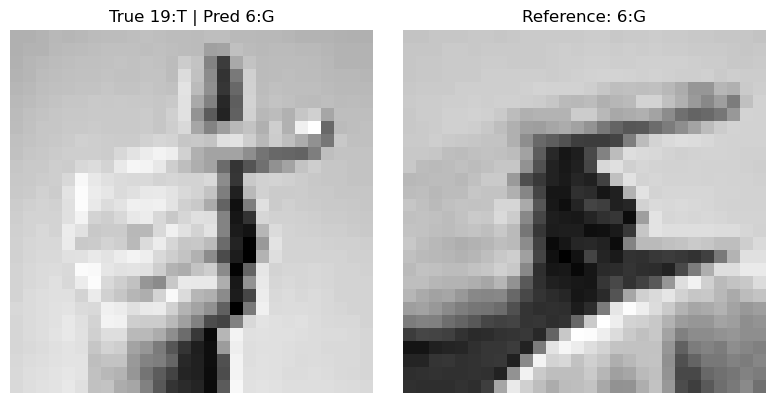

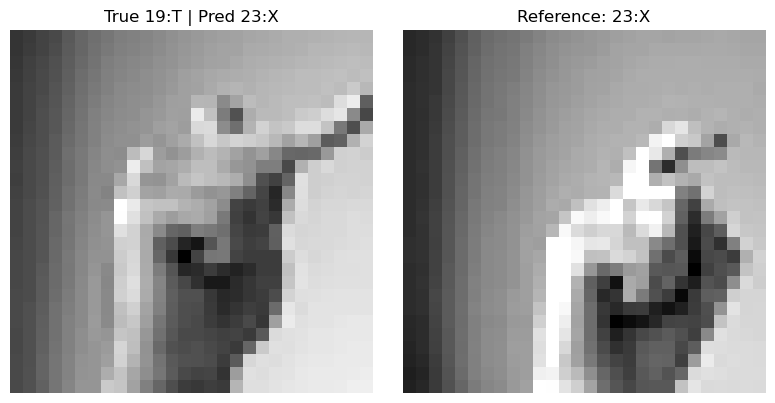

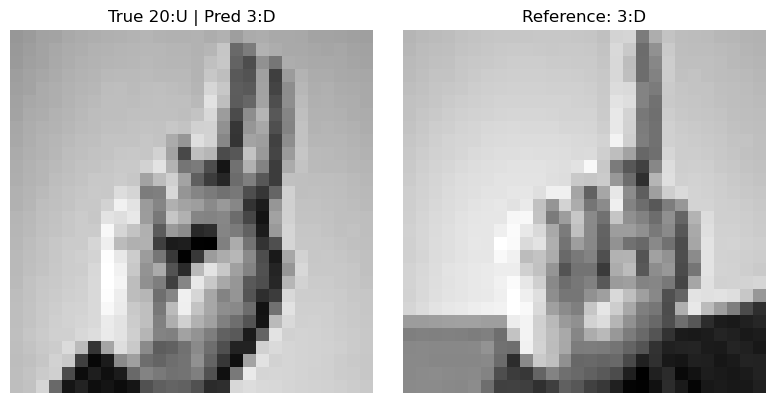

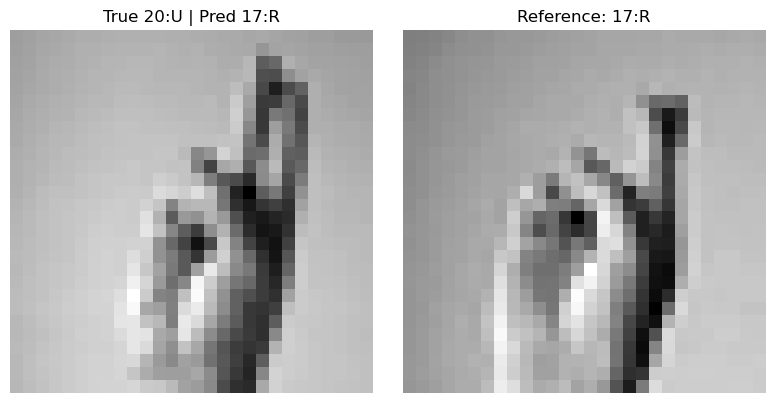

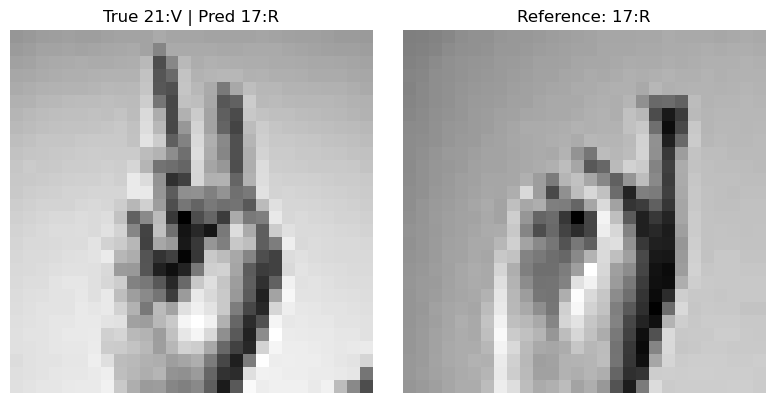

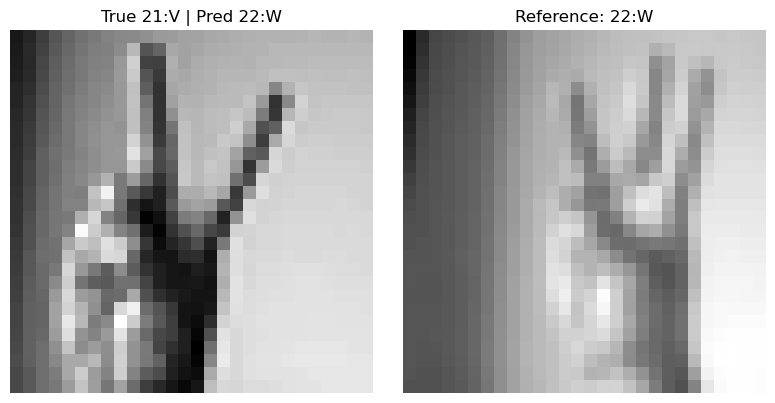

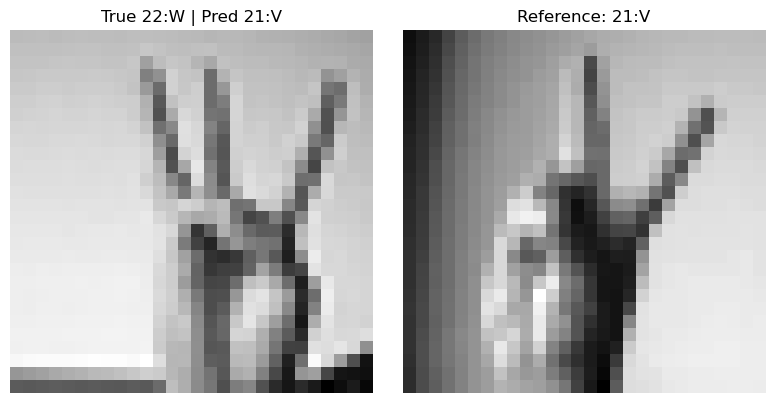

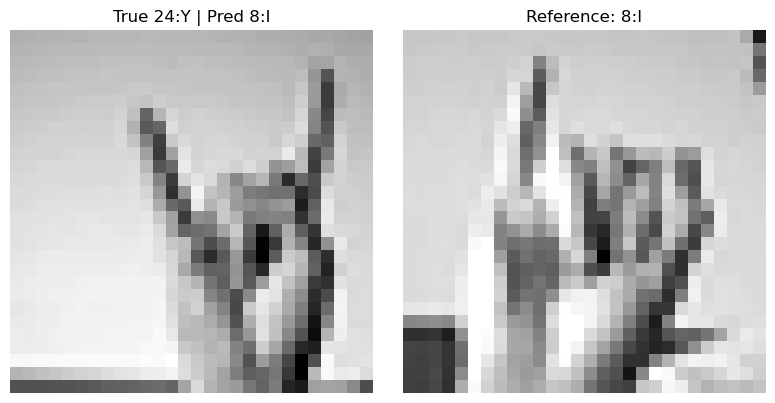

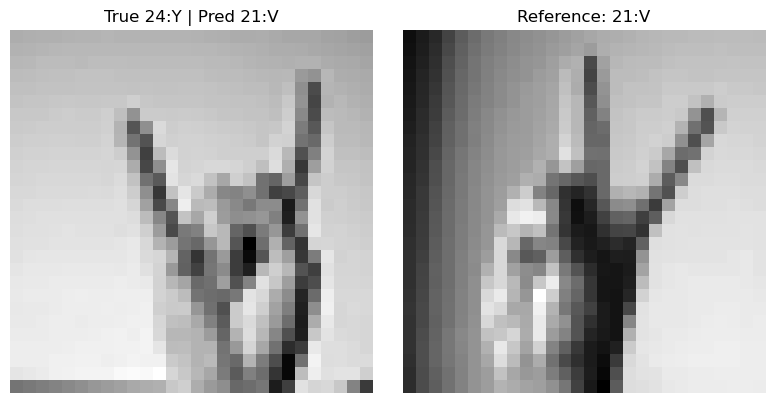

In [479]:
# Shallower Network (Remove one Conv layer)
class ShallowCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.ReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 26)
        )

    def forward(self, x):
        return self.model(x)
    
model_shallow = ShallowCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_shallow.parameters(), lr=0.0001)

run_full_pipeline(
    model=model_shallow,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    label_to_letter=label_to_letter,
    num_classes=num_classes,
    nepochs=10,
    misclass_threshold=10,
    show_prediction_comparison_func=show_prediction_comparison
)

c:\Users\ExoHorizon\anaconda3\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/10] Train Loss: 2.5974, Train Acc: 27.15% | Val Loss: 6.9797, Val Acc: 3.99%
Epoch [2/10] Train Loss: 1.1817, Train Acc: 70.21% | Val Loss: 1.5957, Val Acc: 73.99%
Epoch [3/10] Train Loss: 0.5468, Train Acc: 88.68% | Val Loss: 0.5958, Val Acc: 95.56%
Epoch [4/10] Train Loss: 0.2625, Train Acc: 96.51% | Val Loss: 0.2410, Val Acc: 99.38%
Epoch [5/10] Train Loss: 0.1375, Train Acc: 98.91% | Val Loss: 0.0903, Val Acc: 99.95%
Epoch [6/10] Train Loss: 0.0798, Train Acc: 99.49% | Val Loss: 0.0388, Val Acc: 99.98%
Epoch [7/10] Train Loss: 0.0492, Train Acc: 99.79% | Val Loss: 0.0143, Val Acc: 100.00%
Epoch [8/10] Train Loss: 0.0336, Train Acc: 99.85% | Val Loss: 0.0086, Val Acc: 100.00%
Epoch [9/10] Train Loss: 0.0254, Train Acc: 99.91% | Val Loss: 0.0057, Val Acc: 100.00%
Epoch [10/10] Train Loss: 0.0197, Train Acc: 99.90% | Val Loss: 0.0033, Val Acc: 100.00%
Test Loss: 0.0992, Test Accuracy: 96.99%


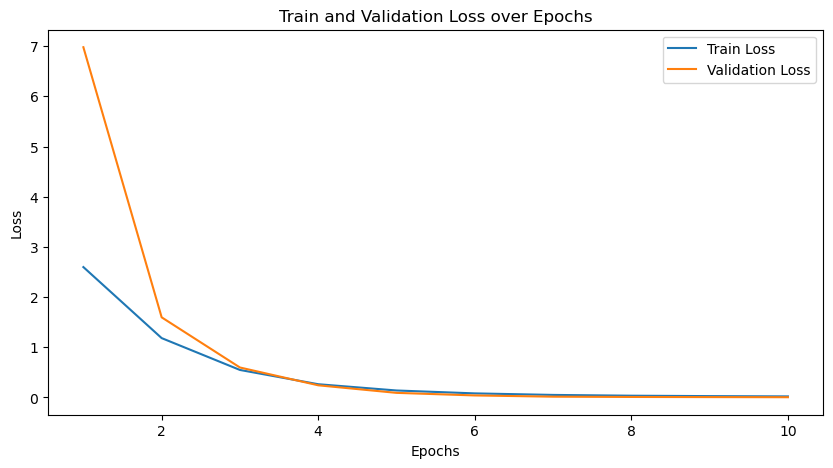

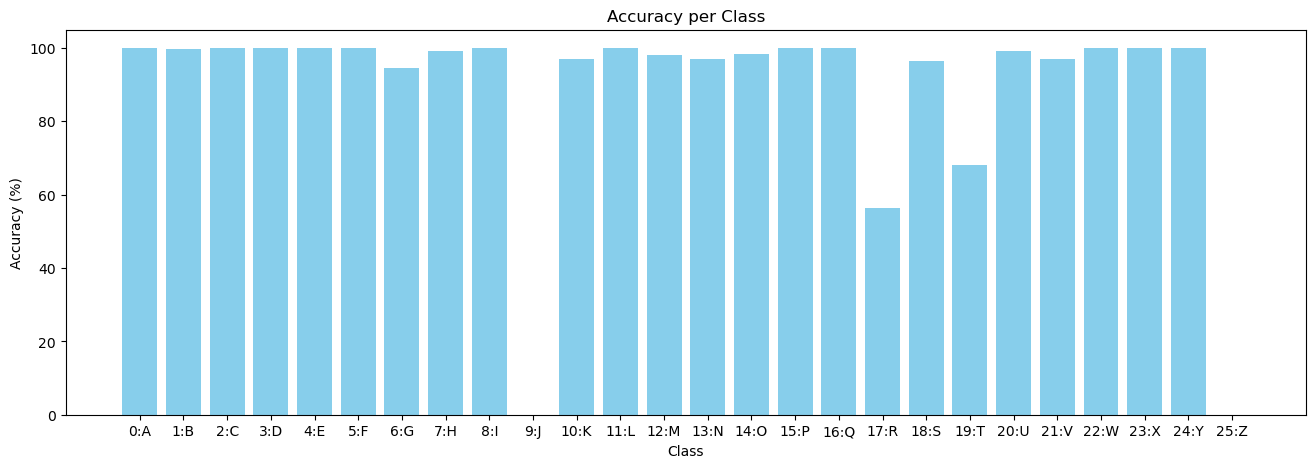

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[100.0, 99.76851851851852, 100.0, 100.0, 100.0, 100.0, 94.54022988505747, 99.31192660550458, 100.0, 0, 96.97885196374622, 100.0, 98.22335025380711, 96.90721649484536, 98.3739837398374, 100.0, 100.0, 56.25, 96.34146341463415, 68.14516129032258, 99.24812030075188, 97.10982658959537, 100.0, 100.0, 100.0, 0]
Most Correct: Label 5, Accuracy: 100.00%
Most Incorrect: Label 17, Accuracy: 56.25%


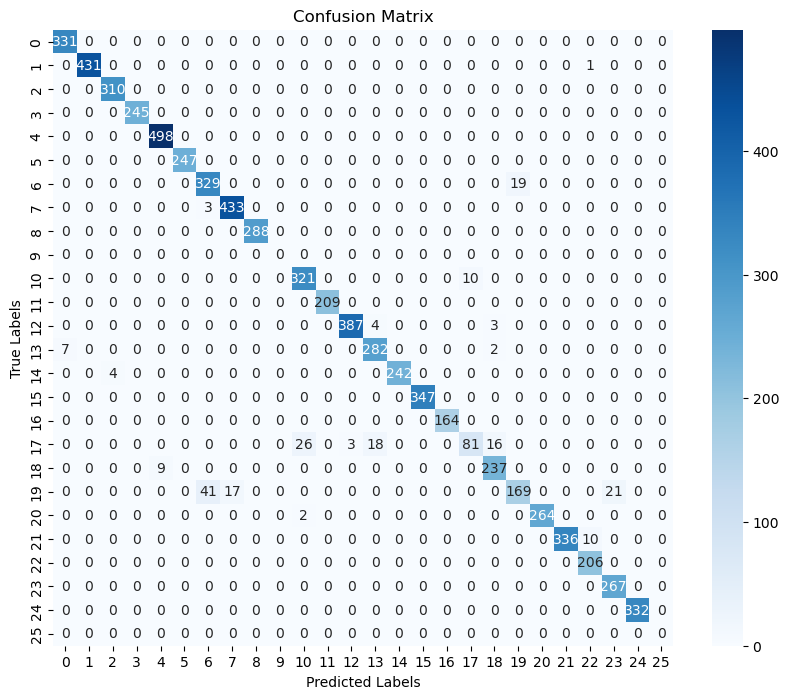

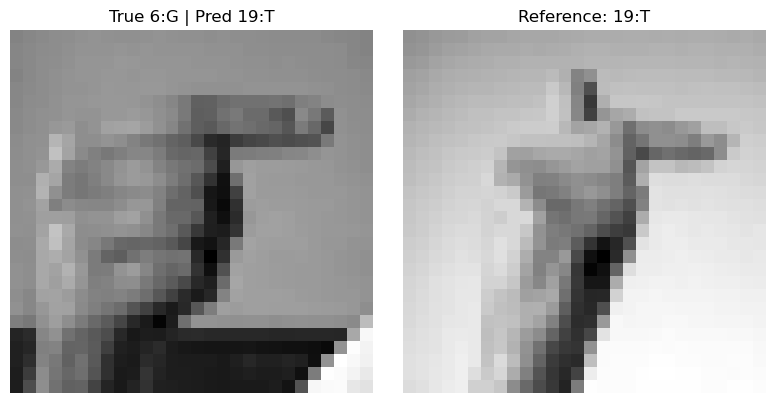

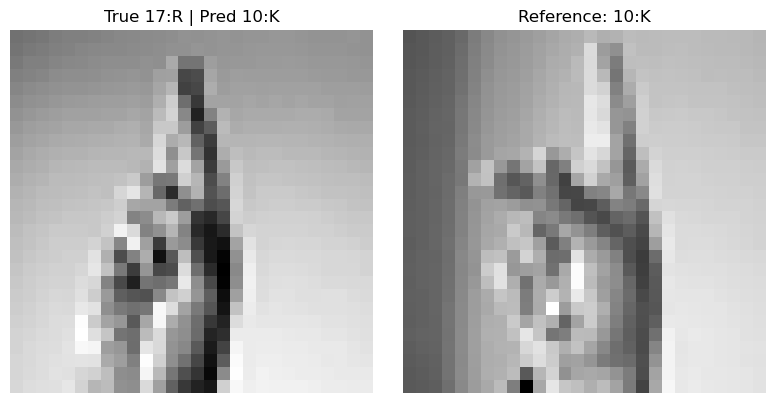

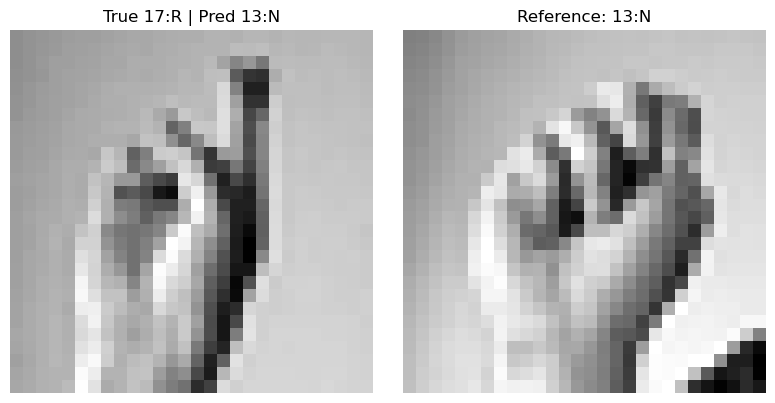

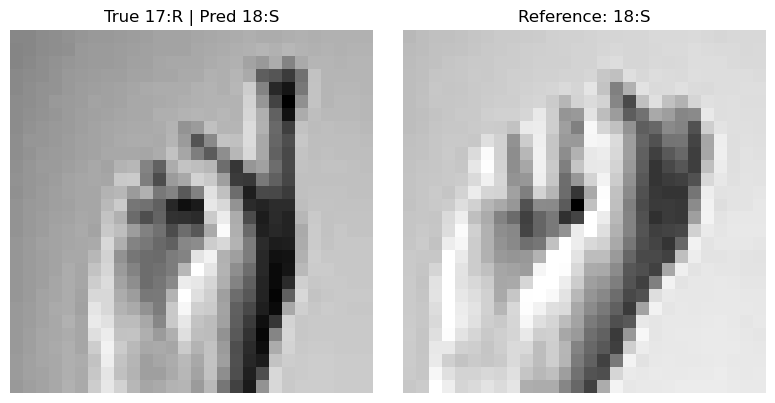

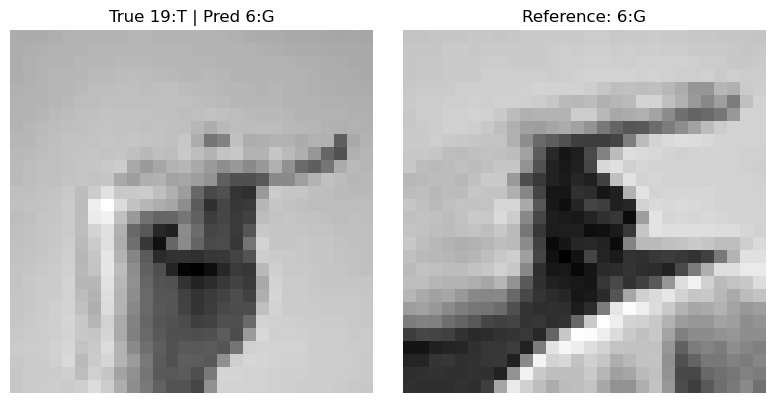

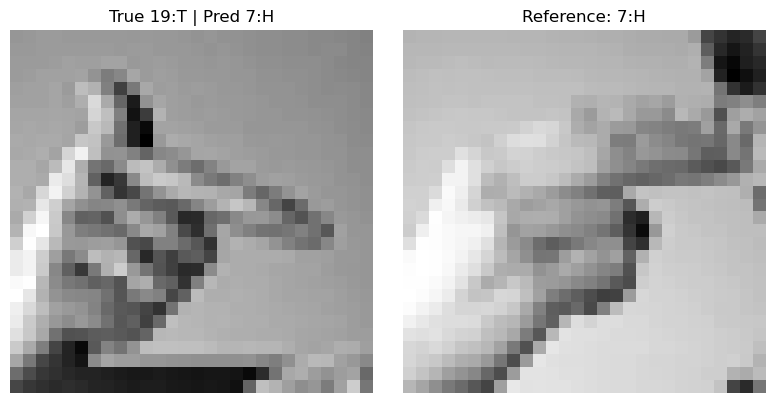

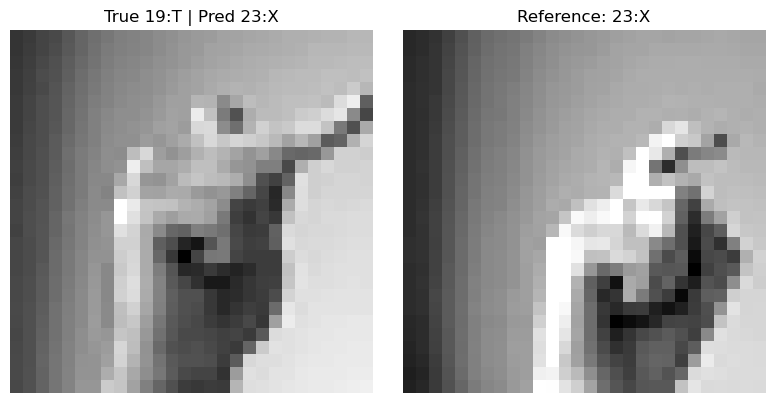

In [480]:
class LeakyReLUCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),

            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.LazyLinear(128),
            nn.LeakyReLU(),
            nn.Dropout(0.5),

            nn.Linear(128, 26)
        )

    def forward(self, x):
        return self.model(x)

model_leaky_relu = LeakyReLUCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_leaky_relu.parameters(), lr=0.0001)

run_full_pipeline(
    model=model_leaky_relu,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    label_to_letter=label_to_letter,
    num_classes=num_classes,
    nepochs=10,
    misclass_threshold=10,
    show_prediction_comparison_func=show_prediction_comparison
)

## Experiment 2: Generalization Study

In [524]:
# Load the generalization study dataset

gen_df = pd.read_csv('American Sign Language Dataset/asl_dataset.csv')
print(f"Gen dataframe shape: {gen_df.shape}")
gen_df.head()

Gen dataframe shape: (1675, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,145,145,145,145,145,145,145,145,145,...,80,34,120,148,145,145,145,145,145,145
1,0,145,145,145,145,145,145,145,145,145,...,89,36,130,147,145,145,145,145,145,145
2,0,145,145,145,145,145,145,145,145,145,...,105,50,119,148,145,145,145,145,145,145
3,0,145,145,145,145,145,145,145,145,145,...,124,56,118,148,145,145,145,145,145,145
4,0,145,145,145,145,145,145,145,145,145,...,89,50,118,148,145,145,145,145,145,145


Text(0, 0.5, 'Count')

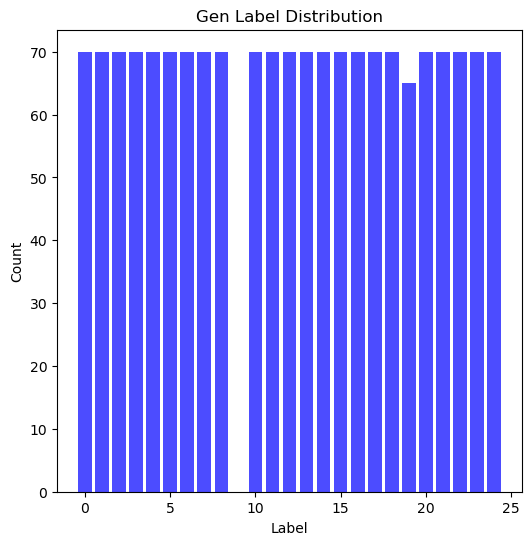

In [525]:
# Check dataset label distribution

gen_labels = gen_df['label'].value_counts()
plt.figure(figsize=(6, 6))

plt.bar(gen_labels.index, gen_labels.values, color='blue', alpha=0.7)
plt.title('Gen Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')

In [526]:
# Separate the labels and features

y_gen_test = gen_df['label'].values
X_gen_test = gen_df.drop('label', axis=1).values

In [527]:
# Reshape the data for CNN input (vector to grayscale image)

X_gen_test= X_gen_test.reshape(-1, 28, 28, 1)

In [528]:
# Show final shape of the data

print(f"Gen test data shape: {X_gen_test.shape}")
print(f"Gen test labels shape: {y_gen_test.shape}")

Gen test data shape: (1675, 28, 28, 1)
Gen test labels shape: (1675,)


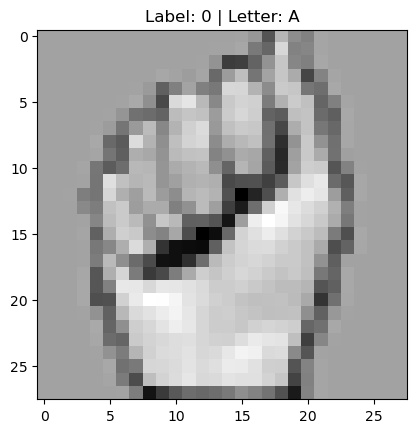

In [529]:
# Show a sample image

plt.imshow(X_gen_test[0].reshape(28, 28), cmap='gray')
plt.title(f"Label: {y_gen_test[0]} | Letter: {label_to_letter[y_gen_test[0]]}")
plt.show()

In [530]:
# Convert the data to PyTorch tensors, create TensorDatasets, and create Dataloaders

X_gen_test_tensor = torch.tensor(X_gen_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_gen_test_tensor = torch.tensor(y_gen_test, dtype=torch.long)
gen_test_dataset = TensorDataset(X_gen_test_tensor, y_gen_test_tensor)
batch_size = 64
gen_test_loader = DataLoader(gen_test_dataset, batch_size=batch_size, shuffle=False)

In [531]:
# Check that the DataLoader works

for images, labels in gen_test_loader:
    print("Batch image shape:", images.shape)  # Expected: [64, 1, 28, 28]
    print("Batch label shape:", labels.shape)  # Expected: [64]
    break

Batch image shape: torch.Size([64, 1, 28, 28])
Batch label shape: torch.Size([64])


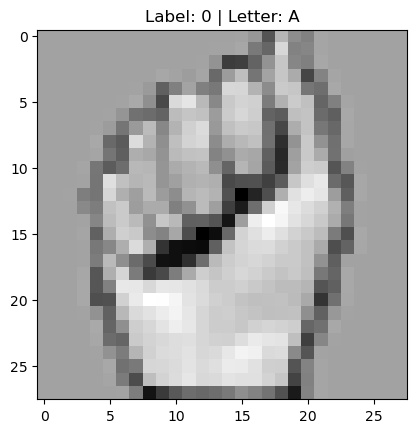

In [532]:
# Check that images are still in the correct format after tensor conversion

plt.imshow(X_gen_test_tensor[0].squeeze().numpy(), cmap='gray')
plt.title(f"Label: {y_gen_test_tensor[0].item()} | Letter: {label_to_letter[y_gen_test_tensor[0].item()]}")
plt.show()

c:\Users\ExoHorizon\anaconda3\Lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch [1/10] Train Loss: 2.6686, Train Acc: 24.72% | Val Loss: 6.5266, Val Acc: 3.52%
Epoch [2/10] Train Loss: 1.2818, Train Acc: 67.38% | Val Loss: 2.6649, Val Acc: 15.10%
Epoch [3/10] Train Loss: 0.5908, Train Acc: 88.15% | Val Loss: 2.4325, Val Acc: 19.88%
Epoch [4/10] Train Loss: 0.2832, Train Acc: 96.44% | Val Loss: 2.4871, Val Acc: 19.94%
Epoch [5/10] Train Loss: 0.1478, Train Acc: 98.68% | Val Loss: 2.5296, Val Acc: 21.67%
Epoch [6/10] Train Loss: 0.0848, Train Acc: 99.49% | Val Loss: 2.6831, Val Acc: 21.19%
Epoch [7/10] Train Loss: 0.0562, Train Acc: 99.69% | Val Loss: 2.9049, Val Acc: 20.48%
Epoch [8/10] Train Loss: 0.0374, Train Acc: 99.85% | Val Loss: 3.0366, Val Acc: 19.16%
Epoch [9/10] Train Loss: 0.0271, Train Acc: 99.90% | Val Loss: 2.8764, Val Acc: 19.46%
Epoch [10/10] Train Loss: 0.0203, Train Acc: 99.90% | Val Loss: 3.0274, Val Acc: 19.82%
Test Loss: 3.1558, Test Accuracy: 20.30%


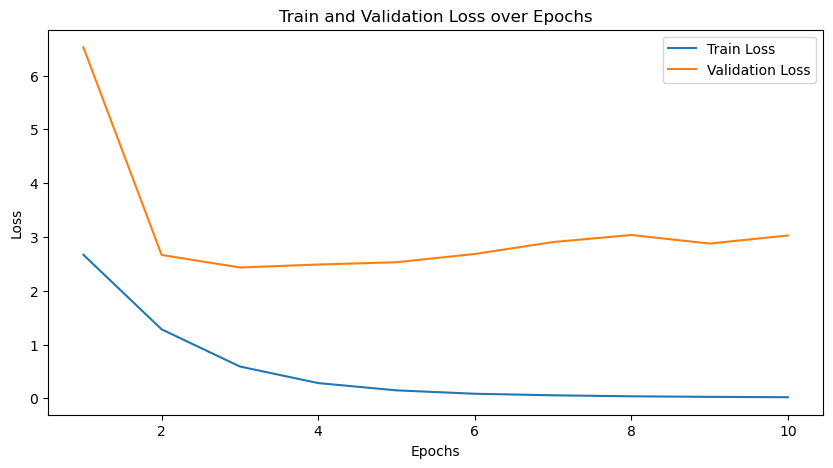

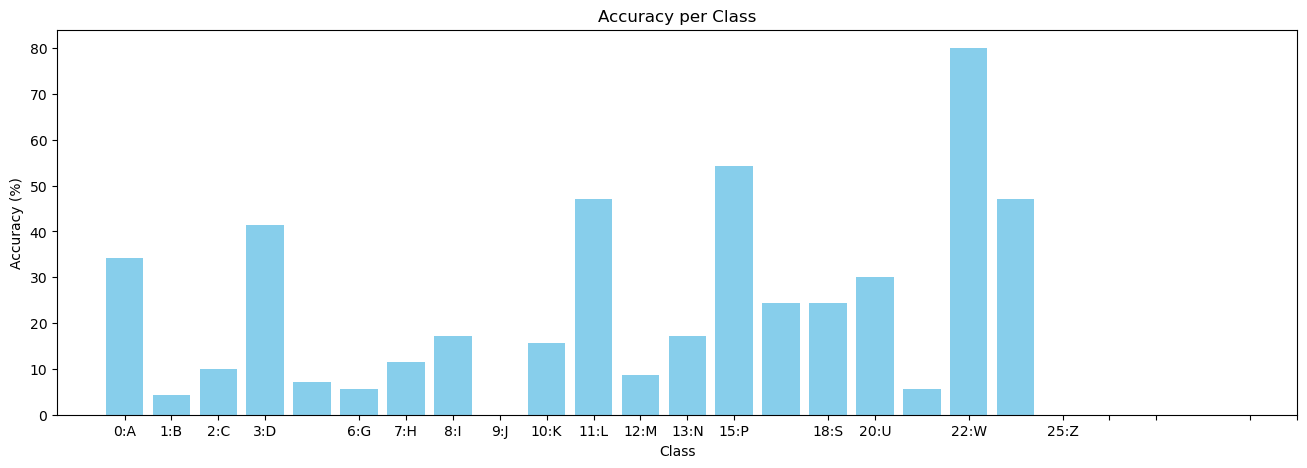

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 18, 20, 21, 22, 24, 25]
[34.285714285714285, 4.285714285714286, 10.0, 41.42857142857143, 7.142857142857142, 5.714285714285714, 11.428571428571429, 17.142857142857142, 0, 15.714285714285714, 47.14285714285714, 8.571428571428571, 17.142857142857142, 54.285714285714285, 24.285714285714285, 24.285714285714285, 30.0, 5.714285714285714, 80.0, 47.14285714285714, 0]
Most Correct: Label 22, Accuracy: 80.00%
Most Incorrect: Label 1, Accuracy: 4.29%


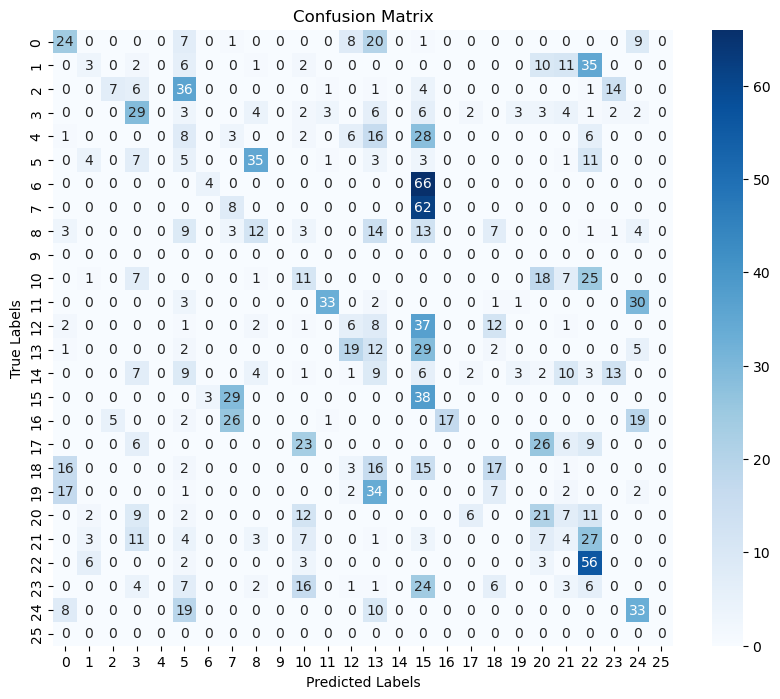

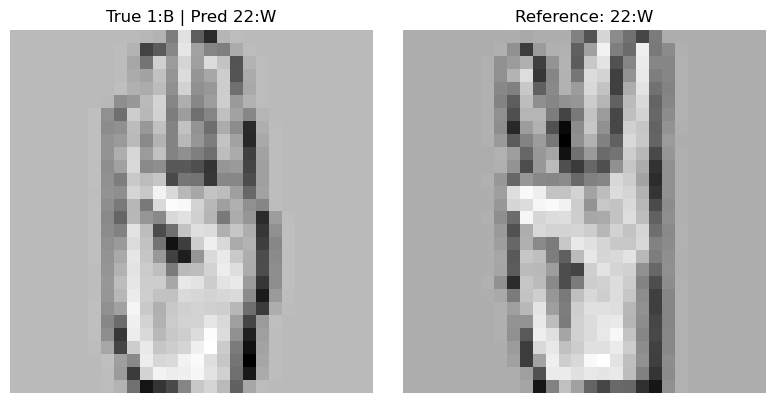

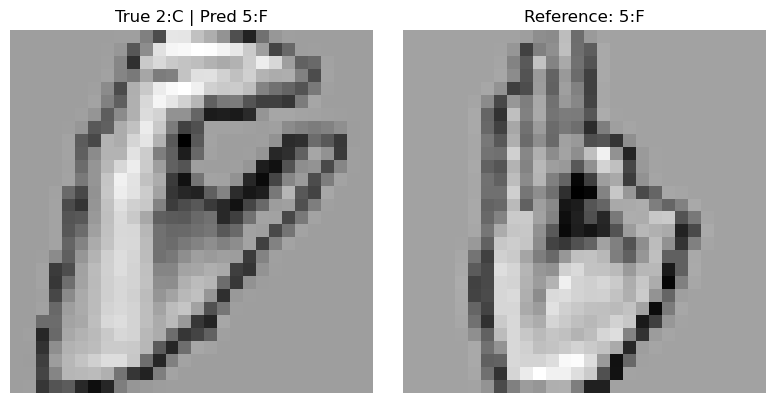

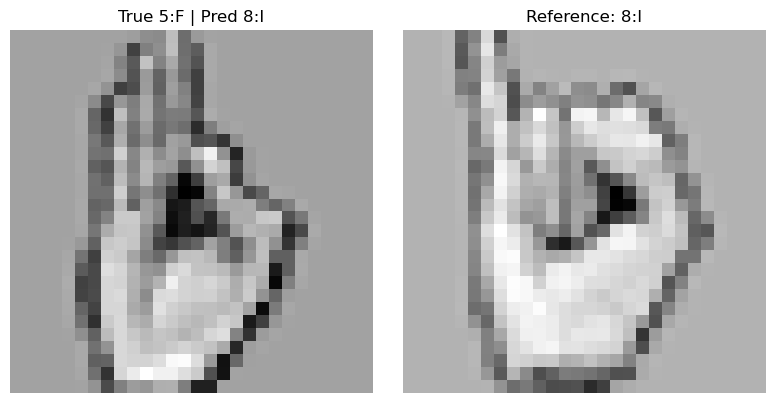

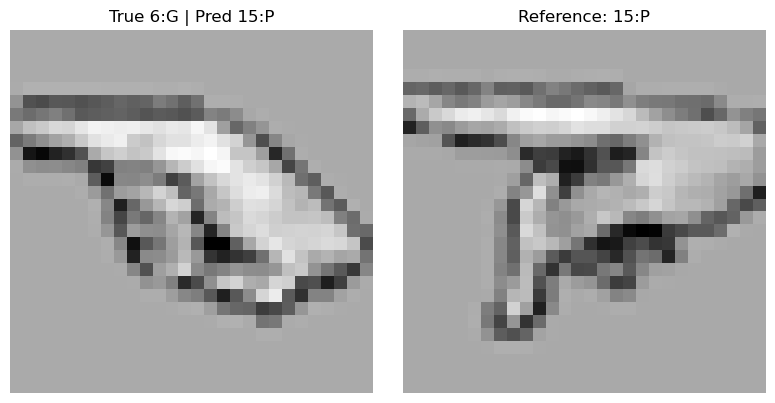

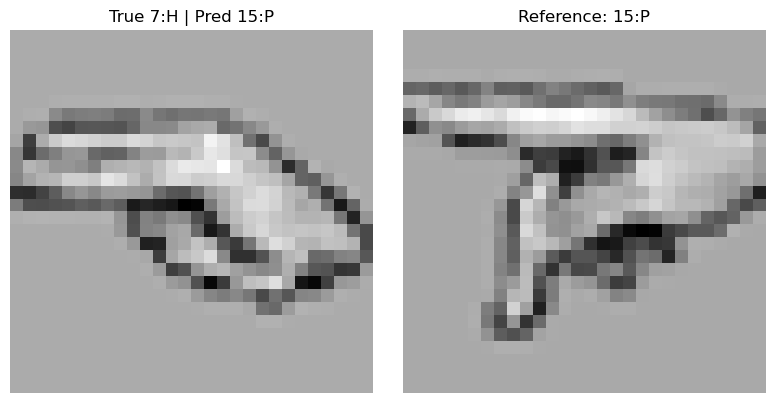

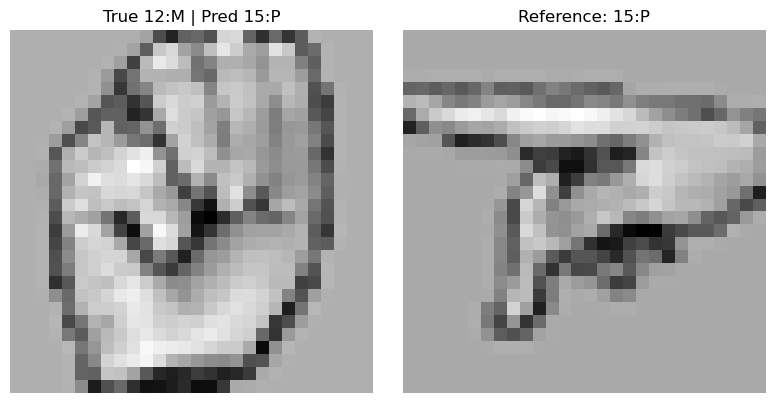

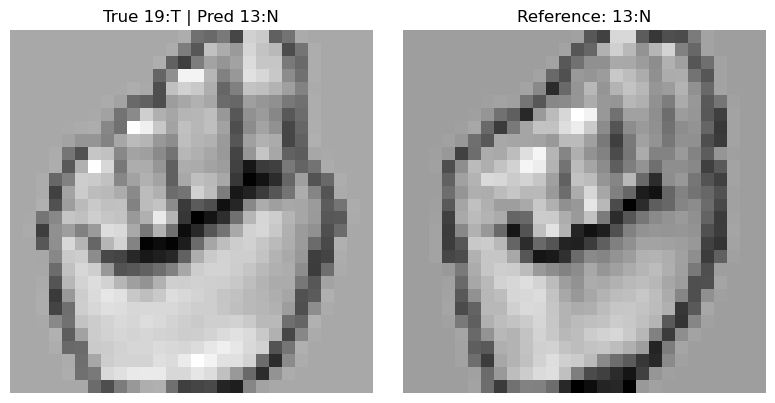

In [540]:
# Run Pipeline For the Model

model = SignLanguageCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

run_full_pipeline(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=gen_test_loader,
    test_loader=gen_test_loader,
    label_to_letter=label_to_letter,
    num_classes=num_classes,
    nepochs=10,
    misclass_threshold=30,
    show_prediction_comparison_func=show_prediction_comparison
)
